In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Setup

We load some pythin packages, and define some settings for displaying pandas data frames and suppress common warning in numpy (which can be savely ignored *here*) to make it easier to look at things.

In [2]:
import os
from tqdm import tqdm

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable

from uncertainties import ufloat
from uncertainties import unumpy as unp

import scipy
import scipy.integrate
import scipy.stats

In [3]:
#from ROOT import gSystem
#gSystem.Load('libanalysis.so')
#from ROOT import Belle2
#Belle2.Variable.Manager.Instance()

In [4]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)

from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [5]:
pd.options.display.float_format = '{:.2f}'.format

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [6]:
from academy.analysis.selection import sig_id_to_label
from academy.analysis.plotting import init_plot_style, data_vs_mc_stacked_hist, add_lumi, add_watermark, color_dict, channel_label, add_channel, chi2, create_hist_ratio_figure, set_yscale, create_ylabel, Tango, calculate_ratio
from academy.analysis.settings import *
from academy.analysis.constants import *

from academy.analysis.fitting import run_fit
from academy.analysis.systematics import *

init_plot_style()

There are the data frames we just downloaded, you might have to adjust the path, if you did not put them in the same directoy as the notebooks.

In [7]:
df_mc = pd.read_hdf('AcademySample.h5')
df_data = pd.read_hdf('AcademySampleData.h5')

The available columns in the data frame are given below.

In [8]:
[col for col in df_mc.columns]

['__weight_overall__',
 'wReco',
 'wMC',
 'costhetalReco',
 'costhetalMC',
 'm2RecoilSignalSide_after_smearing',
 'SIG_ID',
 'daughter__bo1__cm__spextraInfo__bodecayModeID__bc__bc',
 'daughter__bo1__cm__spdaughter__bo0__cm__spextraInfo__bodecayModeID__bc__bc__bc',
 'daughter__bo1__cm__spdaughter__bo0__cm__spdaughter__bo0__cm__spextraInfo__bodecayModeID__bc__bc__bc__bc',
 'weight_ff_btodst_nom',
 'weight_ff_btodst_var_0_up',
 'weight_ff_btodst_var_1_up',
 'weight_ff_btodst_var_2_up',
 'weight_ff_btodst_var_3_up',
 'weight_ff_btodst_var_4_up',
 'weight_ff_btodst_var_5_up',
 'weight_ff_btodst_var_0_down',
 'weight_ff_btodst_var_1_down',
 'weight_ff_btodst_var_2_down',
 'weight_ff_btodst_var_3_down',
 'weight_ff_btodst_var_4_down',
 'weight_ff_btodst_var_5_down']

This is an overview of the decay channels. We usually only differ between channel 15 and 16 (electron and muon), but if you are interesting to split this sample further, you can use the Dstar and D channel id's below

In [9]:
# daughter__bo1__cm__spextraInfo__bodecayModeID__bc__bc
channels = [
    15,  #S B0 -> D*+ e nu
    16,  #S B0 -> D*+ mu nu
]

# daughter__bo1__cm__spdaughter__bo0__cm__spextraInfo__bodecayModeID__bc__bc__bc
channels_Dstar = [
    23,  #S D*+ -> D0 pi+
    24,  #S D*+ -> D+ pi0
]  

# daughter__bo1__cm__spdaughter__bo0__cm__spdaughter__bo0__cm__spextraInfo__bodecayModeID__bc__bc__bc__bc
channels_D = [
    31,  #S D+ -> K- pi+ pi+
    32,  #N D+ -> K- pi+ pi+ pi0
    33,  #N D+ -> K- pi+ pi+ pi+ pi-
    34,  #N D+ -> Ks pi+
    35,  #N D+ -> Ks pi+ pi0
    36,  #N D+ -> Ks pi+ pi+ pi-
    37,  #N D+ -> Ks K^+
    38,  #N D+ -> K+ K- pi^+
    41,  #S D0 -> K- pi+
    42,  #S D0 -> K- pi+ pi0
    43,  #S D0 -> K- pi+ pi+ pi-
    44,  #N D0 -> K- pi+ pi+ pi- pi0
    45,  #N D0 -> Ks pi0
    46,  #N D0 -> Ks pi+ pi-
    47,  #N D0 -> Ks pi+ pi- pi0
    48,  #N D0 -> K+ K+
]

In [10]:
plotoutdir = "output/Fitting"
try:
    os.makedirs(plotoutdir)
except FileExistsError:
    pass

# Fitting

In [11]:
template_categories = {
    "signal": [4.1, 4.2],
    "background": [9, 8, 7, 6, 5, 3],
}

template_category_names = ["background", "signal"]

In [12]:
def chi2_from_templates(templates, option):
    mc_yields = sum(unp.nominal_values(templates[x]) for x in template_category_names)
    data_yields = unp.nominal_values(templates[data_type])
    mc_uncertainty_sq = sum(unp.std_devs(templates[x])**2 for x in template_category_names)
    data_uncertainty_sq = unp.std_devs(templates[data_type])**2
    if option == "asimov_data" or option == "toy_data": 
        uns_sq = mc_uncertainty_sq + data_uncertainty_sq
        return np.sum([x for x in np.nan_to_num((mc_yields - data_yields) ** 2 / uns_sq) if x < 1e7])
    if option == "data": 
        chi_p = []
        for n_i, nu_i in zip(data_yields, mc_yields):
            if n_i > 0: chi_p.append(n_i * np.log(n_i / nu_i) + nu_i - n_i)
        chi_p = 2 * np.sum(chi_p)
        uns_sq = data_uncertainty_sq
        chi = np.sum([x for x in np.nan_to_num((mc_yields - data_yields) ** 2 / uns_sq) if x < 1e7])
        return chi_p

def ndf_from_templates(templates):
    data_yields = unp.nominal_values(templates[data_type])
    ndf = sum([n_i > 0 for n_i in data_yields]) - len(template_categories)
    return ndf


def annotate_gof(ax, templates, ndf, option):
    chi2 = chi2_from_templates(templates, option)
    ndf = ndf_from_templates(templates)
    p_value = scipy.integrate.quad(lambda x: scipy.stats.chi2.pdf(x, df=ndf), chi2, np.inf)[0]
    add_channel(ax[0], r"$\mathbf{\chi^2}_\mathrm{P}$ / ndf = " + f"{chi2:.2f} / {ndf}", px=0.03, py=0.93, fontsize=10)
    add_channel(ax[0], r"p-Value = " + f"{p_value:.4f}", px=0.03, py=0.88, fontsize=10)

    
def plot_templates(
    templates,
    template_categories,
    bins,
    var_str,
    unit,
    y_str,
    data,
    color_dict,
    label_dict,
    full_systematic_covariance=None
    
):
    fig, ax = create_hist_ratio_figure()
    fig.subplots_adjust(hspace=0.1)

    bin_width = abs(fit_bins[0:-1] - fit_bins[1:])
    bin_centers = (fit_bins[0:-1] + fit_bins[1:])/2

    bottom = np.zeros(len(bin_centers))
    for category in template_categories:
        ax[0].bar(
            bin_centers,
            unp.nominal_values(templates[category]),
            width=bin_width,
            bottom=bottom,
            label=label_dict[category],
            color=color_dict[category],
            edgecolor="black", 
            lw=0.5,
        )
        bottom += unp.nominal_values(templates[category])

    ax[0].errorbar(
        bin_centers, 
        unp.nominal_values(templates[data]),
        yerr=unp.std_devs(templates[data]),
        marker='.',
        color='black', 
        ls='',
        label=label_dict[data],
    )
    
    if full_systematic_covariance is None:
        mc_uncertainty = sum([unp.std_devs(templates[category]) for category in template_categories])
        systematic_label = "MC Stat. Unc."
    else:
        mc_uncertainty = (sum([unp.std_devs(templates[category]) for category in template_categories])**2 + full_systematic_covariance.diagonal())**0.5
        systematic_label = "Syst. Unc."
    
    ax[0].bar(
        bin_centers,
        mc_uncertainty,
        width=bin_width,
        bottom=bottom - mc_uncertainty/2,
        color="tab:green", alpha=0.7, hatch="//",
        label=systematic_label,
    )
    
    ax[0].set_ylim(0, ax[0].get_ylim()[1])  # Force ymin=0
    set_yscale(ax[0])
    handles, labels = ax[0].get_legend_handles_labels()
    ax[0].legend(handles[::-1], labels[::-1], frameon=False, fontsize="x-small", ncol=1, loc='upper right')
    ax[0].set_ylabel(create_ylabel(y_str, bin_width, unit))
    var_str = var_str if var_str else column
    x_label = var_str + f" [{unit}]" if unit else var_str
    
    ax[1].set_xlabel(x_label)
    ax[1].set_ylabel(r"Data/MC")
    ax[1].set_axisbelow(True)
    ax[1].grid(axis="y")

    data_ratio = calculate_ratio(
        numerator=unp.nominal_values(templates[data]),
        denominator=sum([unp.nominal_values(templates[category]) for category in template_categories]),
        numerator_uncertainty=unp.std_devs(templates[data]),
        denominator_uncertainty=None
    )

    mc_ratio = calculate_ratio(
        numerator=sum([unp.nominal_values(templates[category]) for category in template_categories]),
        denominator=sum([unp.nominal_values(templates[category]) for category in template_categories]),
        numerator_uncertainty=mc_uncertainty,
        denominator_uncertainty=None
    )
    
    ax[1].errorbar(
        bin_centers,
        unp.nominal_values(data_ratio),
        yerr=unp.std_devs(data_ratio),
        ls="",
        marker=".",
        color="black",
    )
    
    ax[1].bar(
        bin_centers,
        mc_uncertainty/bottom,
        width=bin_width,
        bottom=1 - mc_uncertainty/bottom/2,
        color="tab:green", alpha=1.0, hatch="//",
    )
    ax[1].set_ylim(bottom=0.6, top=1.4)
    
    return fig, ax


Fit Settings

In [13]:
fit_variable = "m2RecoilSignalSide_after_smearing" 
fit_variable_label = r"$M_\mathrm{miss}^2$"
fit_variable_unit = r"GeV$^2$/$c^4$"
fit_bins = np.array([-1.0, -0.25, 0.25, 0.75, 1.25, 2.0])
fit_range = (min(fit_bins), max(fit_bins))
fit_vois = ["wReco", "costhetalReco"]

In [14]:
color_dict = {
    "signal": "tab:orange",
    "background": "tab:blue",
}
label_dict = {
    "signal": r"Signal",
    "background": r"Background",
    "data": "Data",
    "asimov_data": "Asimov Data",
}

Here you can choose if you want to use the data sample or an asimov data set (the latter is useful to validate you fits).

In [15]:
# data_type="asimov_data"
data_type="data"

In [16]:
plotoutdir = os.path.join(plotoutdir, data_type)
try:
    os.makedirs(plotoutdir)
except FileExistsError:
    pass
print(plotoutdir)

output/Fitting/data


## Fit of the inclusive mm2 distribution

### Generating templates from the ntuple

Here we generate the required ntuples for an inclusive fit in mm2, with the settings defined above. 
We also determine the systematic uncertainties from MC statistics and form factors.

In [17]:
templates_pre_fit_total = {}

systematics_index = []
mc_statistics_signal_systematics = {}    
mc_statistics_background_systematics = {}
ff_BtoDst_signal_systematics = {}

for channel in tqdm(channels):
    templates_pre_fit_total[channel] = {}
    
    query = f"daughter__bo1__cm__spextraInfo__bodecayModeID__bc__bc == {channel} and {fit_range[0]} <= {fit_variable} <= {fit_range[1]}"

    mc = df_mc.query(query)
    data = df_data.query(query)

    for category in template_categories:

        n = mc.query(f"SIG_ID in {template_categories[category]}")[fit_variable].values
        w = mc.query(f"SIG_ID in {template_categories[category]}")["__weight_overall__"].values
        bin_index = np.digitize(n, fit_bins)
        # We drop the over and underflow bin here
        bin_content = np.array([np.sum(w[np.where(bin_index == i)]) for i in range(1, len(fit_bins))])
        bin_errors = np.array([np.sqrt(np.sum(w[np.where(bin_index == i)] ** 2)) for i in range(1, len(fit_bins))])

        templates_pre_fit_total[channel][category] = unp.uarray(bin_content, bin_errors)

    bin_content = sum(templates_pre_fit_total[channel][category] for category in template_categories)
    bin_errors = bin_content**0.5
    templates_pre_fit_total[channel]["asimov_data"] = unp.uarray(unp.nominal_values(bin_content), unp.nominal_values(bin_content)**0.5)
    
    toy_sample = scipy.stats.poisson.rvs(unp.nominal_values(bin_content))
    templates_pre_fit_total[channel]["toy_data"] = unp.uarray(toy_sample, toy_sample**0.5)
    
    bin_content = np.histogram(data[fit_variable], bins=fit_bins, range=fit_range, weights=data["__weight_overall__"])[0]
    bin_errors = bin_content**0.5
    templates_pre_fit_total[channel]["data"] = unp.uarray(bin_content, bin_errors)
    
    # --- Systematics ---

    systematics_index.append((r"MC Statistics (Sig.)", channel_label[channel], ))
    subquery = f"SIG_ID in (4.1, 4.2)"
    sub_mc = mc.query(subquery)
    mc_statistics_signal_systematics[channel] = mc_statistics_systematics(sub_mc, fit_variable, fit_bins, fit_range,)

    
    systematics_index.append((r"MC Statistics (Bkg.)", channel_label[channel], ))
    subquery = f"SIG_ID not in (4.1, 4.2)"
    sub_mc = mc.query(subquery)
    mc_statistics_background_systematics[channel] = mc_statistics_systematics(sub_mc, fit_variable, fit_bins, fit_range,)
    
    
    systematics_index.append((r"FF $B\to D^* \ell \nu_\ell$ (Sig.)", channel_label[channel], ))
    subquery = f"SIG_ID in (4.1, 4.2)"
    sub_mc = mc.query(subquery)
    ff_BtoDst_signal_systematics[channel] = form_factor_systematics(
        sub_mc, fit_variable, fit_bins, fit_range,
        "weight_ff_btodst_nom",
        [f"weight_ff_btodst_var_{i}_up" for i in range(0, 6)],
        [f"weight_ff_btodst_var_{i}_down" for i in range(0, 6)],
    )

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.02it/s]


In [18]:
full_systematics= {}
for channel in tqdm(channels):
    full_systematics[channel] = {}
    full_systematics[channel]["signal"] = {}
    full_systematics[channel]["background"] = {}
    
    full_systematics[channel]["signal"]["covariance"] = sum([
        mc_statistics_signal_systematics[channel]["covariance_matrix"],
        ff_BtoDst_signal_systematics[channel]["covariance_matrix"],
    ])
    
    full_systematics[channel]["background"]["covariance"] = sum([
        mc_statistics_background_systematics[channel]["covariance_matrix"],
    ])        
        
    full_systematics[channel]["signal"]["inv_correlation"] = np.linalg.inv(full_systematics[channel]["signal"]["covariance"] / np.outer(
        full_systematics[channel]["signal"]["covariance"].diagonal()**0.5, full_systematics[channel]["signal"]["covariance"].diagonal()**0.5))
    
    full_systematics[channel]["background"]["inv_correlation"] = np.linalg.inv(full_systematics[channel]["background"]["covariance"] / np.outer(
        full_systematics[channel]["background"]["covariance"].diagonal()**0.5, full_systematics[channel]["background"]["covariance"].diagonal()**0.5))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 2711.25it/s]


In [19]:
full_covariance_for_plotting = {}

for channel in channels:
    full_covariance_for_plotting[channel] = sum([
        full_systematics[channel]["signal"]["covariance"],
        full_systematics[channel]["background"]["covariance"],
    ])

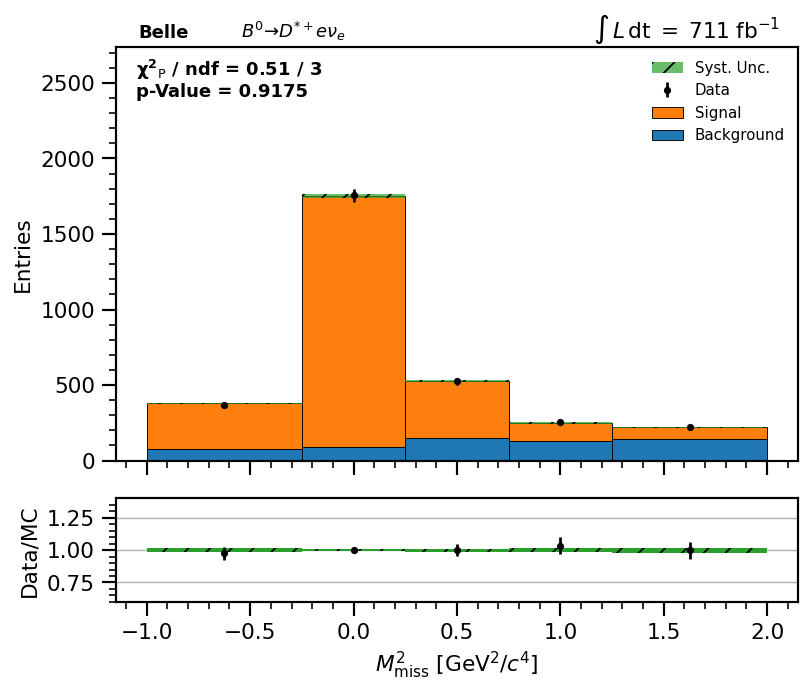

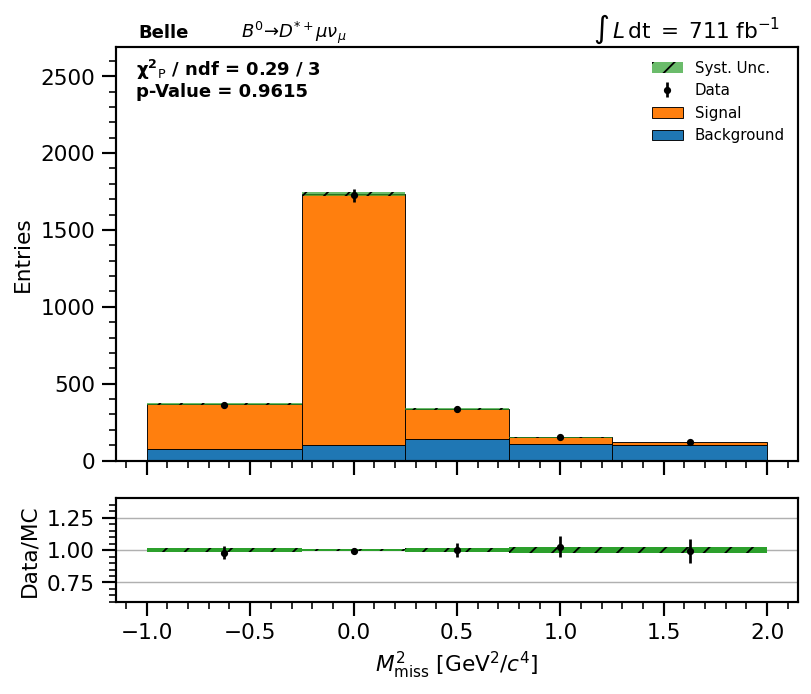

In [20]:
for channel in channels:
    templates = templates_pre_fit_total[channel]
    fig, ax = plot_templates(
        templates=templates,
        template_categories=template_category_names,
        bins=fit_bins,
        var_str=fit_variable_label,
        unit=fit_variable_unit,
        y_str="Entries",
        data=data_type,
        color_dict=color_dict,
        label_dict=label_dict,
        full_systematic_covariance=full_covariance_for_plotting[channel],
    )

    add_lumi(ax[0], 711)
    add_watermark(ax[0], channel_label[channel], fontsize=10)
    annotate_gof(ax, templates, len(fit_bins) - 1 - len(template_categories), option=data_type)
    plt.tight_layout()
    plt.savefig(f"{plotoutdir}/prefit_channel{channel}_inclusive.pdf", transparent=True)
    plt.savefig(f"{plotoutdir}/prefit_channel{channel}_inclusive.png", transparent=True) 
    plt.show()
    plt.close()

***
### Exercise 1: Likelihood Functions

\begin{equation}
    \mathcal{L}(\eta_{k=1,2}, \vec{\theta}) = \prod_{i=1}^\text{bins} \mathcal{P}(n_i | \nu_i(\theta)) \times \prod_k^\text{templates} \mathcal{N}(\theta | 0, \Sigma^k)
\end{equation}
with
\begin{equation}
    \begin{aligned}
        \nu_i(\theta) &= \sum_k^\text{templates} f_{ik}(\theta_k) \eta_k \,,\\
        f_{ik}(\theta_k) &= \frac{\eta_{ik} (1 + \theta_{ik} \epsilon_{ik})}{\sum_j^\text{bins} \eta_{jk} (1 + \theta_{jk} \epsilon_{jk})} \,.
    \end{aligned}
\end{equation}
$\mathcal{P}(n_i|\nu_i(\theta))$ is the Poisson distribution in each bin, depending on the number of measured signal events $n_i$
and the MC expectation $\nu_i(\theta)$, which depends on nuisance parameters $\theta$. In each bin, two nuisance parameter contribute:
One for the signal and one for the background. This directly defines the number of nuisance parameters to the 
number of bins times the number of template categories. $\eta_{ik}$ defines the expected yield of the template $k$ 
($k\in\{\text{Signal}, \text{Background}\}$) in bin $i$ ($\eta_{ik}$ are not nuisance parameters), and $\varepsilon_{ik}$ is the associated systematic uncertainty in that bin 
for that template. $\mathcal{N}$ is a (number of bins)-dimensional normal distribution, with exepcation value 0 in each dimension
and the variance is given by a (number of bins) $\times$ (number of bins) correlation matrix $\Sigma^k$ from
$C^k_\mathrm{tot} = \sum_\text{sources} C^k_\text{systematic uncertainty}$.

In [21]:
from academy.analysis.fitting import prepare_fit

Ex.1 a) The first exercise is to define Likelihood functions for the statistical only case and with systematics. 

The functions have a predefined argument list and return value, so they are compatible with with the rest of the code. 
We can use the `run_fit` function and pass the Likelihood, that will return the fit result. There is an example execution provided below for testing.  If this executes properly, then the fitting should also work.

In [22]:
def L(x, *pars):
    
    data, templates = x
    nBins = len(data)
    
    # Ex. 1a)
    
    if np.isposinf(likelihood):  # Catch pathological cases where L is evaluated outside of sound boundaries
        return 0
    return likelihood

# Teste execution of the likelihood function
sample, x0 = prepare_fit(templates_pre_fit_total[channel], data_type, template_categories)
L(sample, *x0)

-31220.165905851096

Ex.1 b) Now we implement the full case which includes the systematic uncertainties

The functions have a predefined argument list and return value, so they are compatible with with the rest of the code. 
We can use the wrapper functions defined below and use the wrapped function with the `run_fit` function and pass the Likelihood, that will return the fit result. There is an example execution provided below for testing. If this executes properly, then the fitting should also work.

In [23]:
def Lsys(x,
         systematics,
         *pars):
    # templates[0] = signal
    # templates[1] = background
    data, (sig, bkg) = x 
    nBins = len(data)
    
    nTemplates = 2 
    nParamaterOfInterest = nTemplates
    nParameterOfNuisance = nTemplates * nBins
    par_interest = pars[:nParamaterOfInterest]
    par_nuisance = pars[nParamaterOfInterest:nParamaterOfInterest+nParameterOfNuisance]
        
    par_nuisance_sig = par_nuisance[:nBins]
    par_nuisance_bkg = par_nuisance[nBins:]

    sig_errors = systematics[0]["covariance"].diagonal()**0.5 / unp.nominal_values(sig)
    bkg_errors = systematics[1]["covariance"].diagonal()**0.5 / unp.nominal_values(bkg)
    sig_errors = np.nan_to_num(sig_errors)  # In case for 0 entries in template
    bkg_errors = np.nan_to_num(bkg_errors)  # In case for 0 entries in template
    
    # Ex 1b)
    
    if np.isposinf(likelihood):  # Catch pathological cases where L is evaluated outside of sound boundaries
        return 0
    return likelihood

# Teste execution of the likelihood function
sample, x0 = prepare_fit(templates_pre_fit_total[channel], data_type, template_categories)
Lsys(sample, [full_systematics[channel]["signal"], full_systematics[channel]["background"]], *unp.nominal_values(x0), *np.zeros(20))

-31220.165905851096

***

### Statistical only fits

Here we use our Likelihood function `L`.

In [24]:
fit_results_total = {}

fit_options = {
    "options": {"maxiter": 200, "disp": False},   
}

for channel in tqdm(channels):
    fit_results_total[channel] = {}

    fit_result = run_fit(L, templates_pre_fit_total[channel], data_type, template_categories, **fit_options)
    fit_results_total[channel] = fit_result
    if fit_result.status:
        print(f"{channel}_n/a_{i_bin}_{fit_result.message}")
    if np.isnan(fit_result.covariance).any():
        print(f"{channel}_n/a_{i_bin}_Hesse determination failed.")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.48it/s]


### Statistical + Systematics fits

Here we use our Likelihood function `Lsys`.

In [25]:
fit_results_total_with_systematics = {}

fit_options = {
    "options": {"maxiter": 200, "disp": False},   
}

for channel in tqdm(channels):
    fit_results_total_with_systematics[channel] = {}
    
    def Lwrapper(sample, *pars):
        return Lsys(sample, [full_systematics[channel]["signal"], full_systematics[channel]["background"]], *pars)
    x0nuisance = unp.uarray(np.zeros(2*(len(fit_bins)-1)), np.ones(2*(len(fit_bins)-1)))
    
    fit_result = run_fit(Lwrapper, templates_pre_fit_total[channel], data_type, template_categories, x0nuisance, **fit_options)
    fit_results_total_with_systematics[channel] = fit_result
    if fit_result.status:
        print(f"{channel}_n/a_{i_bin}_{fit_result.message}")
    if np.isnan(fit_result.covariance).any():
        print(f"{channel}_n/a_{i_bin}_Hesse determination failed.")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.40s/it]


### Plot Fit Results

In [26]:
templates_post_fit_total = {}

signal_nuisance = slice(2, len(fit_bins)+1)
background_nuisance = slice(len(fit_bins)+1, 2*len(fit_bins)+2)

for channel in channels:
    templates_post_fit_total[channel] = {}

    for i_yield, category in enumerate(template_categories):
        pre_fit = unp.nominal_values(templates_pre_fit_total[channel][category])
        relative_errors = full_systematics[channel][category]["covariance"].diagonal()**0.5 / pre_fit
        relative_errors = np.nan_to_num(relative_errors)
        pull = 1 + fit_results_total_with_systematics[channel].x[signal_nuisance] * relative_errors
        pre_fit_times_pull = (pre_fit * pull)
        fractions = (pre_fit_times_pull) / sum(pre_fit_times_pull)

        templates_post_fit_total[channel][category] = fractions * fit_results_total_with_systematics[channel].x[i_yield]
        
    templates_post_fit_total[channel]["data"] = templates_pre_fit_total[channel]["data"]
    templates_post_fit_total[channel]["asimov_data"] = templates_pre_fit_total[channel]["asimov_data"]
    templates_post_fit_total[channel]["toy_data"] = templates_pre_fit_total[channel]["toy_data"]

In [27]:
full_covariance_for_plotting = {}

for channel in channels:
    full_covariance_for_plotting[channel] = sum([
        full_systematics[channel]["signal"]["covariance"],
        full_systematics[channel]["background"]["covariance"],
    ])

In [28]:
yields = []
index = []
for channel in channels:
    index.append(channel_label[channel])
    yields.append({
        "Channel": channel_label[channel],
        "Signal Pre-Fit": ufloat(fit_results_total[channel].x0[0], fit_results_total[channel].covariance0[0, 0]**0.5),
        "Signal Post-Fit": ufloat(fit_results_total[channel].x[0], fit_results_total[channel].covariance[0, 0]**0.5),
        "Signal Post-Fit w/ Shape": ufloat(fit_results_total_with_systematics[channel].x[0], fit_results_total_with_systematics[channel].covariance[0, 0]**0.5),
        "Background Pre-Fit": ufloat(fit_results_total[channel].x0[1], fit_results_total[channel].covariance0[1, 1]**0.5),
        "Background Post-Fit": ufloat(fit_results_total[channel].x[1], fit_results_total[channel].covariance[1, 1]**0.5),
        "Background Post-Fit w/ Shape": ufloat(fit_results_total_with_systematics[channel].x[1], fit_results_total_with_systematics[channel].covariance[1, 1]**0.5),
        r"$\chi^2$ / ndf Pre-Fit": "{:.3f} / {}".format(chi2_from_templates(templates_pre_fit_total[channel], option=data_type), len(fit_bins) - 1 - len(template_categories)),
        r"$\chi^2$ / ndf Post-Fit": "{:.3f} / {}".format(chi2_from_templates(templates_post_fit_total[channel], option=data_type), len(fit_bins) - 1 - len(template_categories)),
    })

In [29]:
yields = pd.DataFrame(yields, index=index)
yields["Signal Post/Pre"] = unp.nominal_values(yields["Signal Post-Fit"] / yields["Signal Pre-Fit"])
yields["Background Post/Pre"] = unp.nominal_values(yields["Background Post-Fit"] / yields["Background Pre-Fit"])

In [30]:
yields.transpose()

$B^0 \to D^{*+} e \nu_e$  \
Channel                       $B^0 \to D^{*+} e \nu_e$   
Signal Pre-Fit                                2530+/-4   
Signal Post-Fit                      (2.53+/-0.06)e+03   
Signal Post-Fit w/ Shape             (2.53+/-0.07)e+03   
Background Pre-Fit                         592.8+/-2.7   
Background Post-Fit                    (6.0+/-0.5)e+02   
Background Post-Fit w/ Shape           (6.0+/-0.5)e+02   
$\chi^2$ / ndf Pre-Fit                       0.506 / 3   
$\chi^2$ / ndf Post-Fit                      0.381 / 3   
Signal Post/Pre                                   1.00   
Background Post/Pre                               1.01   

                              $B^0 \to D^{*+} \mu \nu_\mu$  
Channel                       $B^0 \to D^{*+} \mu \nu_\mu$  
Signal Pre-Fit                                    2183+/-4  
Signal Post-Fit                          (2.17+/-0.05)e+03  
Signal Post-Fit w/ Shape                 (2.16+/-0.06)e+03  
Background Pre-Fit                             529.0+/-2.6  
Background Post-Fit                        (5.3+/-0.4)e+02  
Background Post-Fit w/ Shape               (5.3+/-0.4)e+02  
$\chi^2$ / ndf Pre-Fit                           0.292 / 3  
$\chi^2$ / ndf Post-Fit                          0.149 / 3  
Signal Post/Pre                                       0.99  
Background Post/Pre                                   1.00

## Fit in bins of w and cosThetaL

### Generating templates from the ntuple

Here we generate the required ntuples for a fit in mm2 in bins of w and cosThetaL, with the settings defined above. 
We also determine the systematic uncertainties from MC statistics and form factors.

Nota Bene: We basically repeat what we already learned! It just looks more complicated, because we have to remember in which bin we are currently working (that is in most cases, just an additional layer of a loop)

In [31]:
templates_pre_fit = {}

mc_statistics_signal_systematics = {}    
mc_statistics_background_systematics = {}
ff_BtoDst_signal_systematics = {}

for channel in tqdm(channels):
    
    templates_pre_fit[channel] = {}
    
    mc_statistics_signal_systematics[channel] = {}    
    mc_statistics_background_systematics[channel] = {}
    ff_BtoDst_signal_systematics[channel] = {}

    for voi in fit_vois:
        templates_pre_fit[channel][voi] = {}

        mc_statistics_signal_systematics[channel][voi] = {}    
        mc_statistics_background_systematics[channel][voi] = {}
        ff_BtoDst_signal_systematics[channel][voi] = {}
        
        bin_edges = bin_edges_all[voi]
        for i_bin, voi_bin in enumerate(zip(bin_edges, bin_edges[1:])):
    

            query = f"daughter__bo1__cm__spextraInfo__bodecayModeID__bc__bc == {channel} and {voi_bin[0]} < {voi} < {voi_bin[1]}" + f" and {fit_range[0]} <= {fit_variable} <= {fit_range[1]}"

            mc = df_mc.query(query)
            data = df_data.query(query)

            templates_pre_fit[channel][voi][i_bin] = {}
            for category in template_categories:

                n = mc.query(f"SIG_ID in {template_categories[category]}")[fit_variable].values
                w = mc.query(f"SIG_ID in {template_categories[category]}")["__weight_overall__"].values
                bin_index = np.digitize(n, fit_bins)
                # We drop the over and underflow bin here
                bin_content = np.array([np.sum(w[np.where(bin_index == i)]) for i in range(1, len(fit_bins))])
                bin_errors = np.array([np.sqrt(np.sum(w[np.where(bin_index == i)] ** 2)) for i in range(1, len(fit_bins))])
                
                templates_pre_fit[channel][voi][i_bin][category] = unp.uarray(bin_content, bin_errors)

            bin_content = sum(templates_pre_fit[channel][voi][i_bin][category] for category in template_categories)
            bin_errors = bin_content**0.5
            templates_pre_fit[channel][voi][i_bin]["asimov_data"] = unp.uarray(unp.nominal_values(bin_content), unp.nominal_values(bin_content)**0.5)
            
            toy_sample = scipy.stats.poisson.rvs(unp.nominal_values(bin_content))
            templates_pre_fit[channel][voi][i_bin]["toy_data"] = unp.uarray(toy_sample, toy_sample**0.5)
            
            bin_content = np.histogram(data[fit_variable], bins=fit_bins, range=fit_range, weights=data["__weight_overall__"])[0]
            bin_errors = bin_content**0.5
            templates_pre_fit[channel][voi][i_bin]["data"] = unp.uarray(bin_content, bin_errors)
            
            
            # --- Systematics ---
            
            subquery = f"SIG_ID in (4.1, 4.2)"
            sub_mc = mc.query(subquery)
            mc_statistics_signal_systematics[channel][voi][i_bin] = mc_statistics_systematics(sub_mc, fit_variable, fit_bins, fit_range,)


            subquery = f"SIG_ID not in (4.1, 4.2)"
            sub_mc = mc.query(subquery)
            mc_statistics_background_systematics[channel][voi][i_bin] = mc_statistics_systematics(sub_mc, fit_variable, fit_bins, fit_range,)    
            
            
            subquery = f"SIG_ID in (4.1, 4.2)"
            sub_mc = mc.query(subquery)
            ff_BtoDst_signal_systematics[channel][voi][i_bin] = form_factor_systematics(
                sub_mc, fit_variable, fit_bins, fit_range,
                "weight_ff_btodst_nom",
                [f"weight_ff_btodst_var_{i}_up" for i in range(0, 6)],
                [f"weight_ff_btodst_var_{i}_down" for i in range(0, 6)],
            )

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.41s/it]


In [32]:
uncorrelated_systematics = {}
for channel in channels:
    uncorrelated_systematics[channel] = {}
    for voi in fit_vois:
        bin_edges = bin_edges_all[voi]
        uncorrelated_systematics[channel][voi] = {}
        
        for i_bin, _ in enumerate(zip(bin_edges, bin_edges[1:])):
            uncorrelated_systematics[channel][voi][i_bin] = {}
            uncorrelated_systematics[channel][voi][i_bin]["signal"] = {}
            uncorrelated_systematics[channel][voi][i_bin]["background"] = {}

            uncorrelated_systematics[channel][voi][i_bin]["signal"]["covariance"] = mc_statistics_signal_systematics[channel][voi][i_bin]["covariance_matrix"]
            uncorrelated_systematics[channel][voi][i_bin]["signal"]["covariance"] += np.identity(uncorrelated_systematics[channel][voi][i_bin]["signal"]["covariance"].shape[0]) * 1e-7  # Sanitize
            uncorrelated_systematics[channel][voi][i_bin]["background"]["covariance"] = mc_statistics_background_systematics[channel][voi][i_bin]["covariance_matrix"]
            uncorrelated_systematics[channel][voi][i_bin]["background"]["covariance"] += np.identity(uncorrelated_systematics[channel][voi][i_bin]["background"]["covariance"].shape[0]) * 1e-7  # Sanitize
                

            uncorrelated_systematics[channel][voi][i_bin]["signal"]["inv_correlation"] = np.linalg.inv(uncorrelated_systematics[channel][voi][i_bin]["signal"]["covariance"] / np.outer(
                uncorrelated_systematics[channel][voi][i_bin]["signal"]["covariance"].diagonal()**0.5, uncorrelated_systematics[channel][voi][i_bin]["signal"]["covariance"].diagonal()**0.5))

            uncorrelated_systematics[channel][voi][i_bin]["background"]["inv_correlation"] = np.linalg.inv(uncorrelated_systematics[channel][voi][i_bin]["background"]["covariance"] / np.outer(
                uncorrelated_systematics[channel][voi][i_bin]["background"]["covariance"].diagonal()**0.5, uncorrelated_systematics[channel][voi][i_bin]["background"]["covariance"].diagonal()**0.5))

In [33]:
full_systematics = {}
for channel in channels:
    full_systematics[channel] = {}
    for voi in fit_vois:
        bin_edges = bin_edges_all[voi]
        full_systematics[channel][voi] = {}
        
        for i_bin, _ in enumerate(zip(bin_edges, bin_edges[1:])):
            full_systematics[channel][voi][i_bin] = {}
            full_systematics[channel][voi][i_bin]["signal"] = {}
            full_systematics[channel][voi][i_bin]["background"] = {}

            full_systematics[channel][voi][i_bin]["signal"]["covariance"] = sum([
                mc_statistics_signal_systematics[channel][voi][i_bin]["covariance_matrix"],
            ])
            full_systematics[channel][voi][i_bin]["signal"]["covariance"] += np.identity(full_systematics[channel][voi][i_bin]["signal"]["covariance"].shape[0]) * 1e-7  # Sanitize

            full_systematics[channel][voi][i_bin]["background"]["covariance"] = sum([
                mc_statistics_background_systematics[channel][voi][i_bin]["covariance_matrix"]
            ])
            full_systematics[channel][voi][i_bin]["background"]["covariance"] += np.identity(full_systematics[channel][voi][i_bin]["background"]["covariance"].shape[0]) * 1e-7  # Sanitize

            full_systematics[channel][voi][i_bin]["signal"]["inv_correlation"] = np.linalg.inv(full_systematics[channel][voi][i_bin]["signal"]["covariance"] / np.outer(
                full_systematics[channel][voi][i_bin]["signal"]["covariance"].diagonal()**0.5, full_systematics[channel][voi][i_bin]["signal"]["covariance"].diagonal()**0.5))

            full_systematics[channel][voi][i_bin]["background"]["inv_correlation"] = np.linalg.inv(full_systematics[channel][voi][i_bin]["background"]["covariance"] / np.outer(
                full_systematics[channel][voi][i_bin]["background"]["covariance"].diagonal()**0.5, full_systematics[channel][voi][i_bin]["background"]["covariance"].diagonal()**0.5))

In [34]:
full_covariance_for_plotting = {}
for channel in channels:
    full_covariance_for_plotting[channel] = {}
    for voi in fit_vois:
        full_covariance_for_plotting[channel][voi] = {}
        bin_edges = bin_edges_all[voi]
        for i_bin, _ in enumerate(zip(bin_edges, bin_edges[1:])):
            full_covariance_for_plotting[channel][voi][i_bin] = sum([
                full_systematics[channel][voi][i_bin]["signal"]["covariance"],
                full_systematics[channel][voi][i_bin]["background"]["covariance"],
            ])

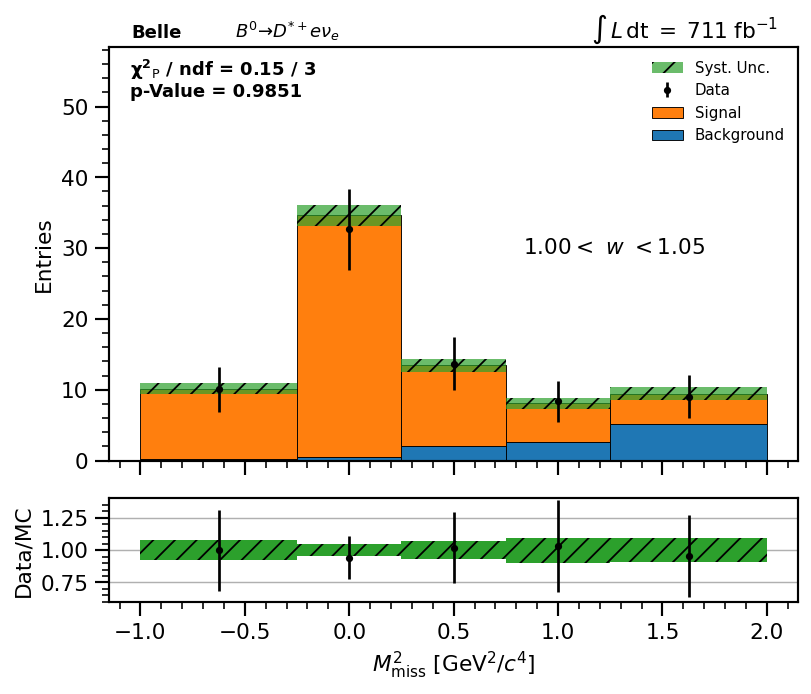

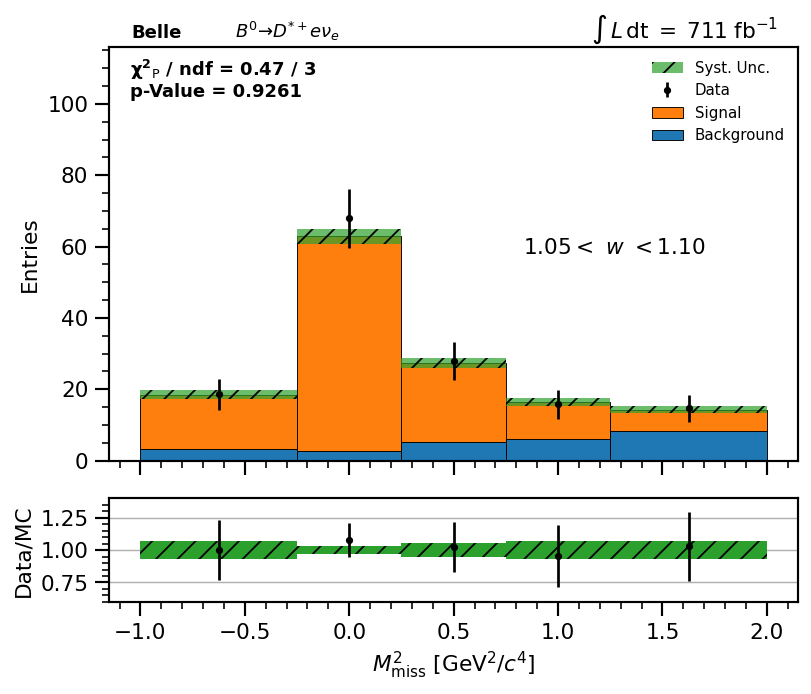

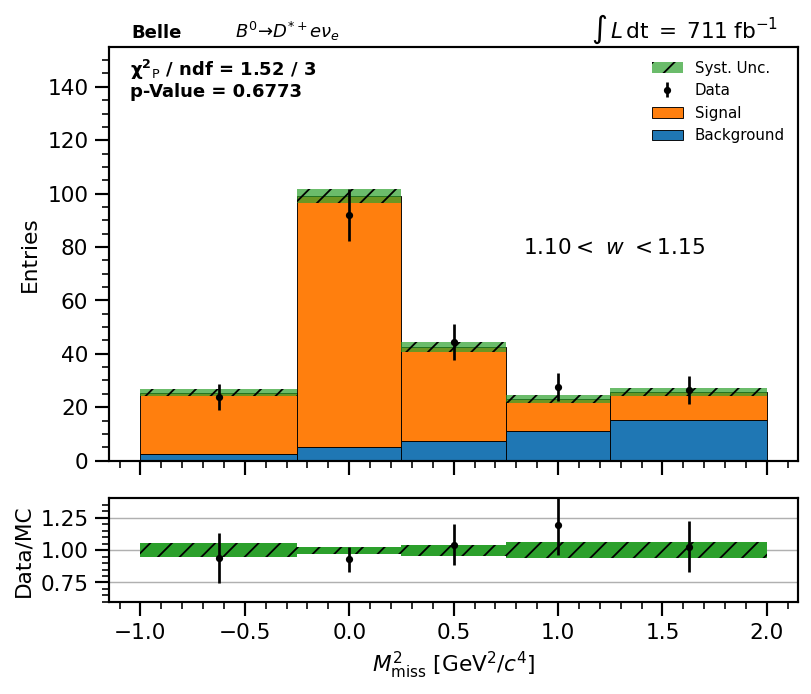

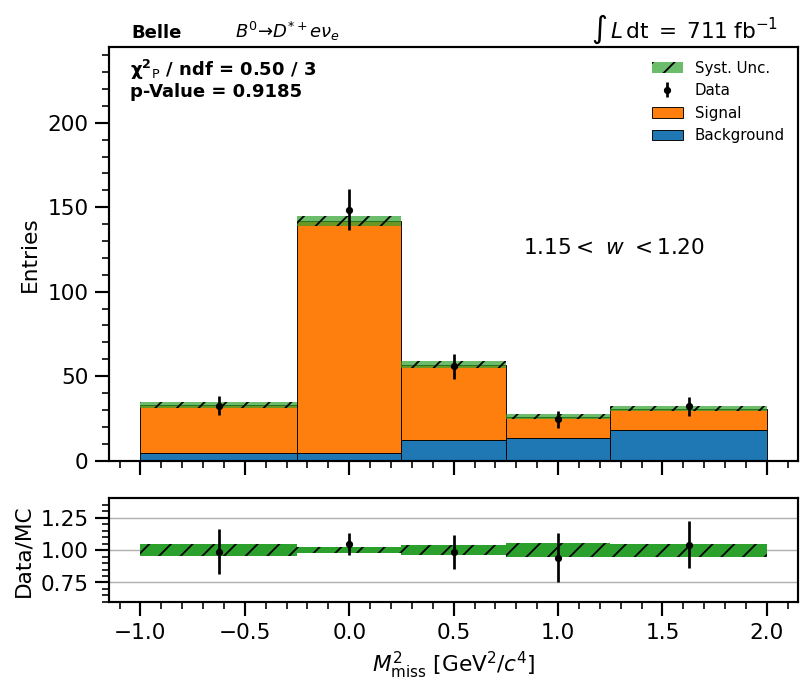

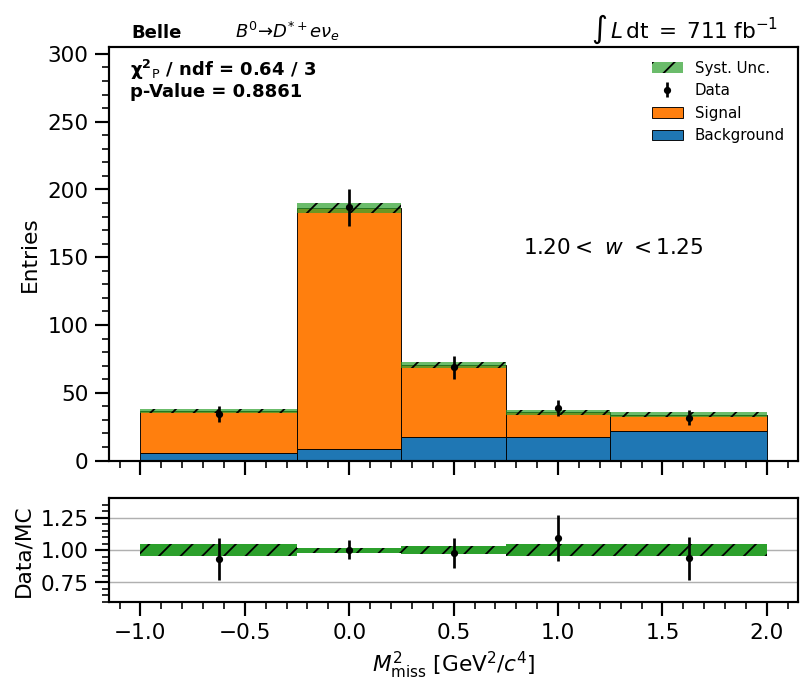

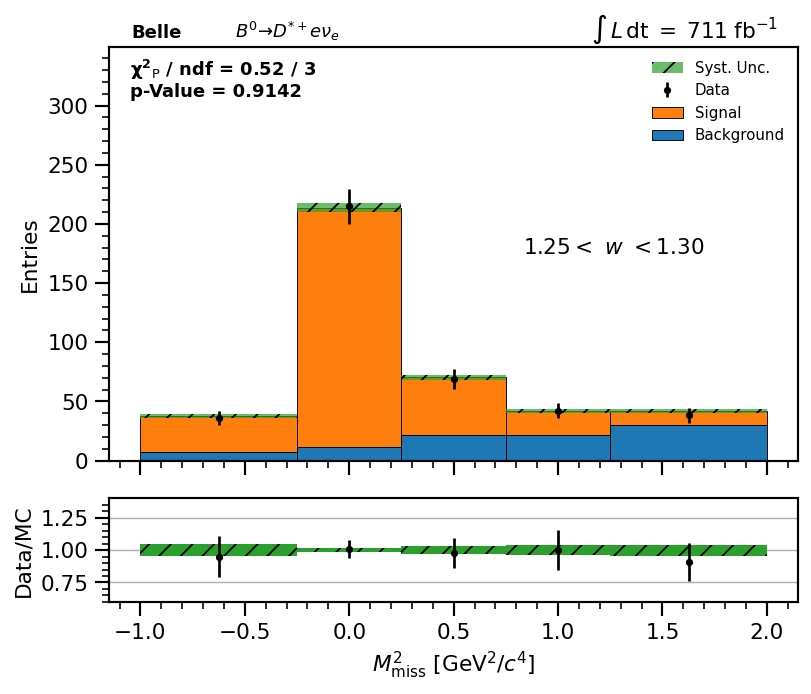

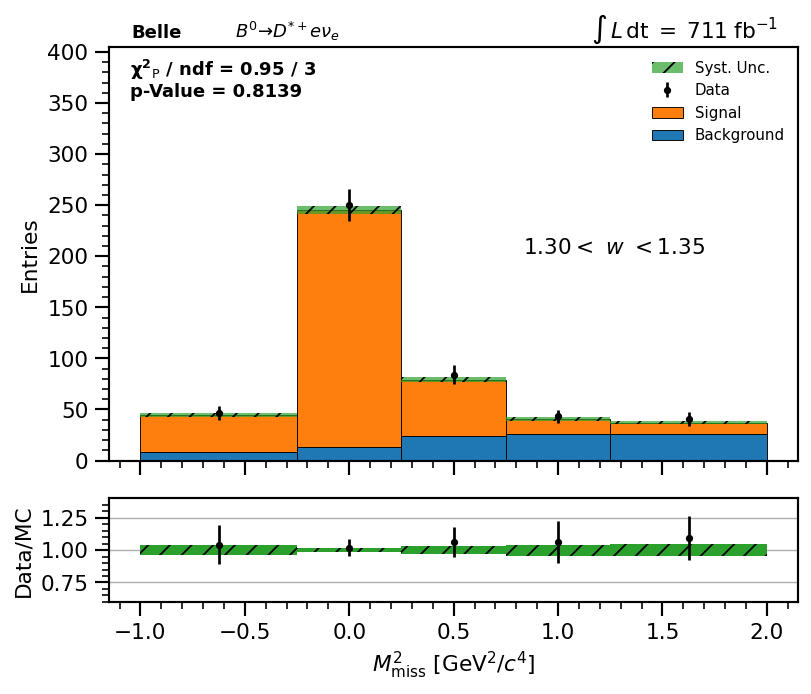

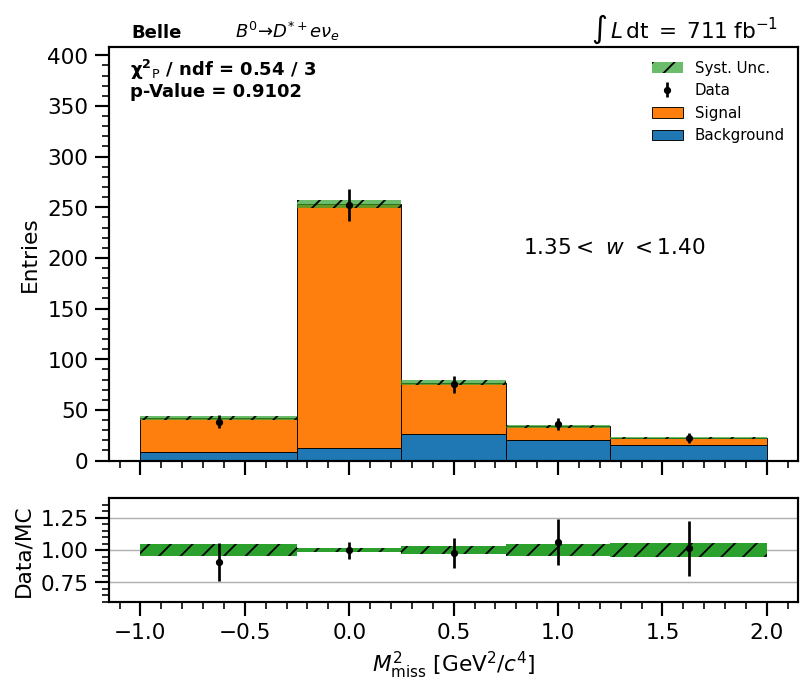

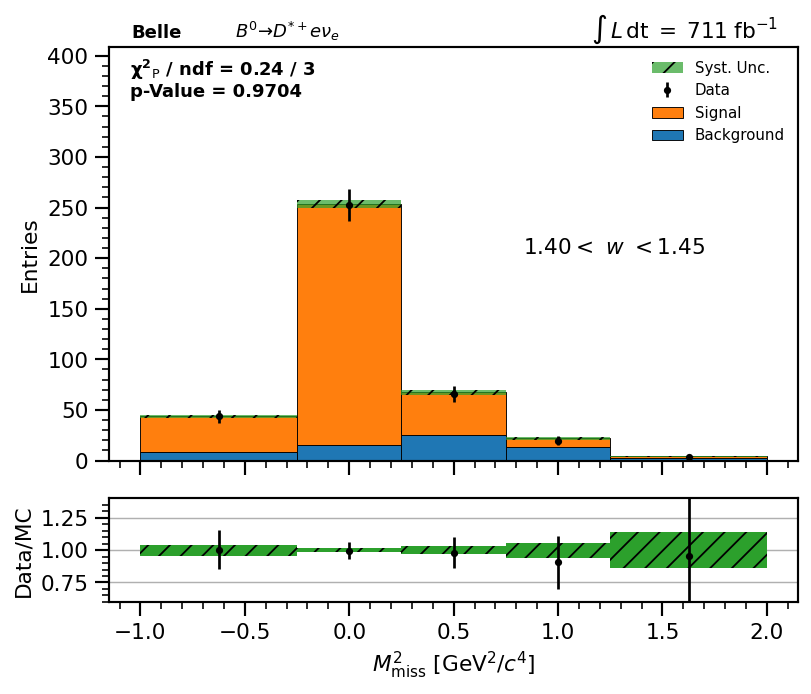

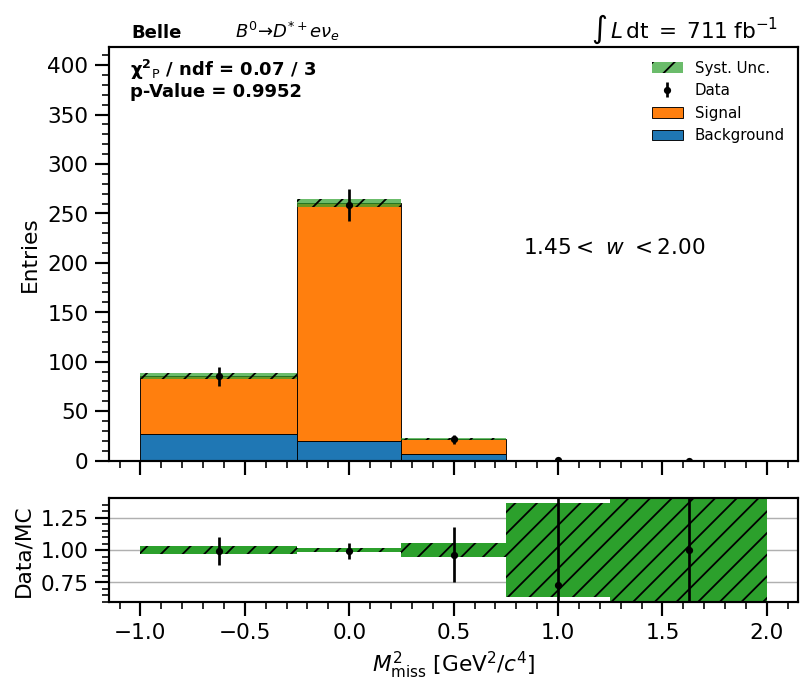

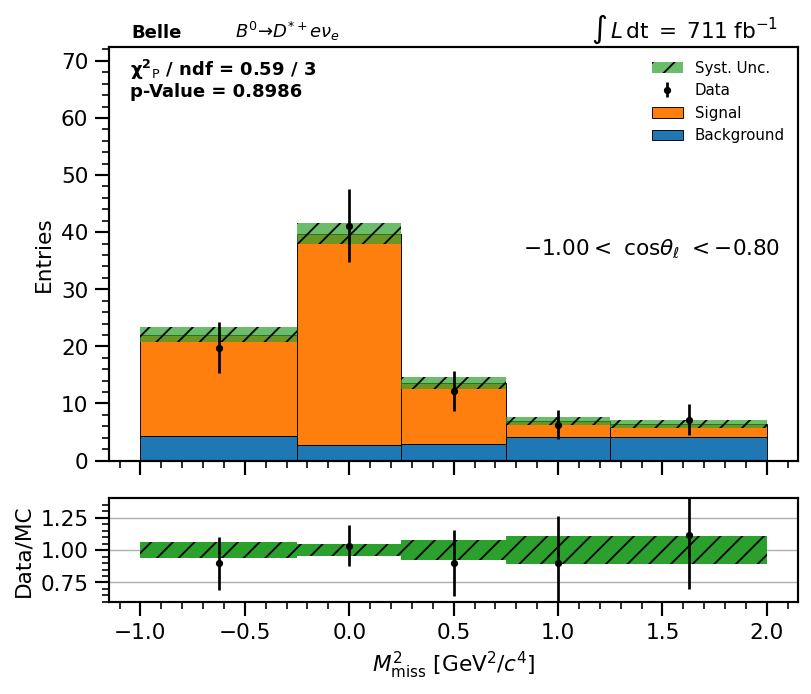

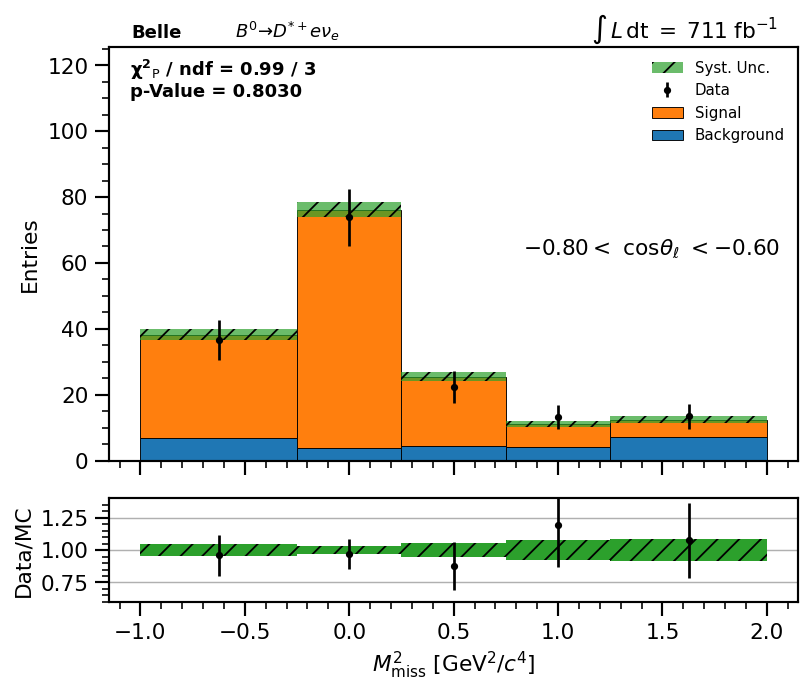

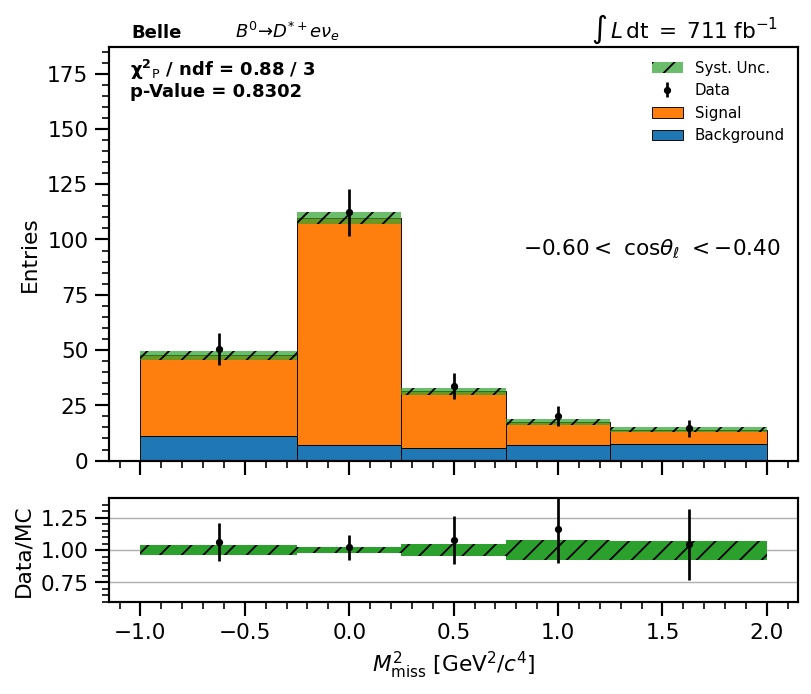

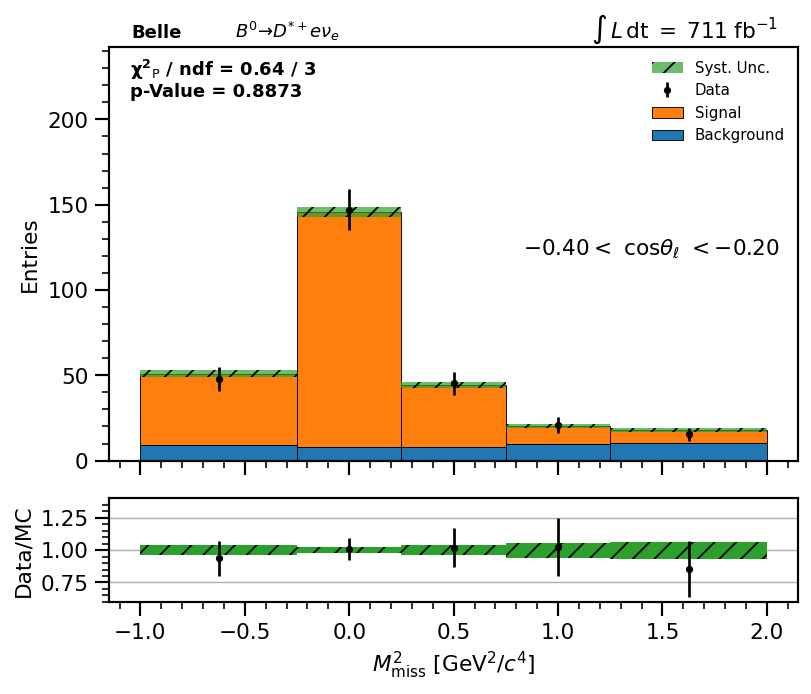

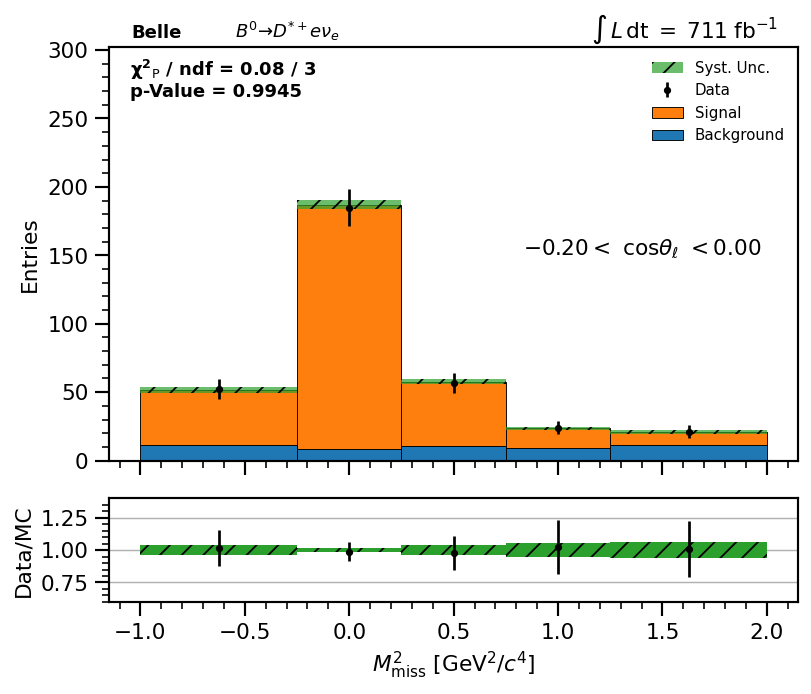

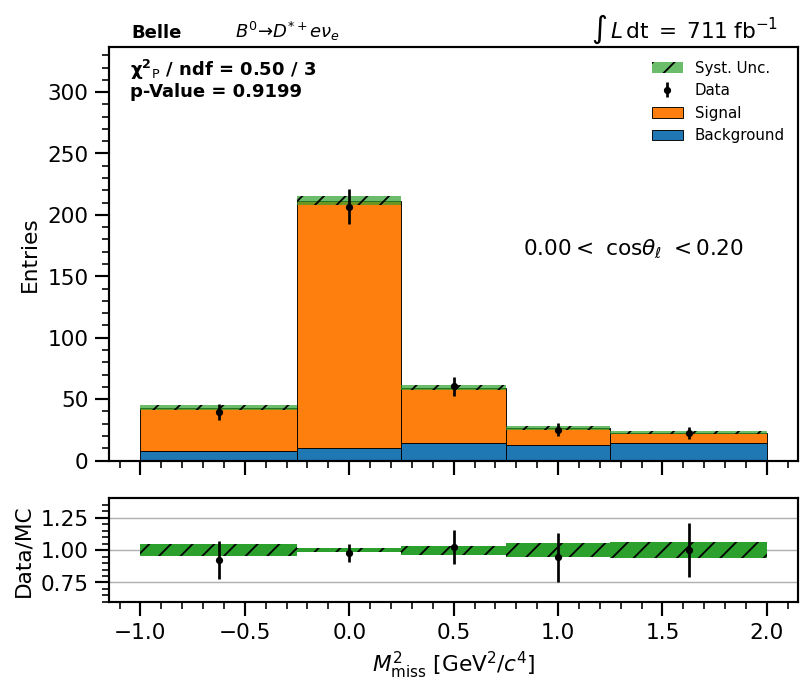

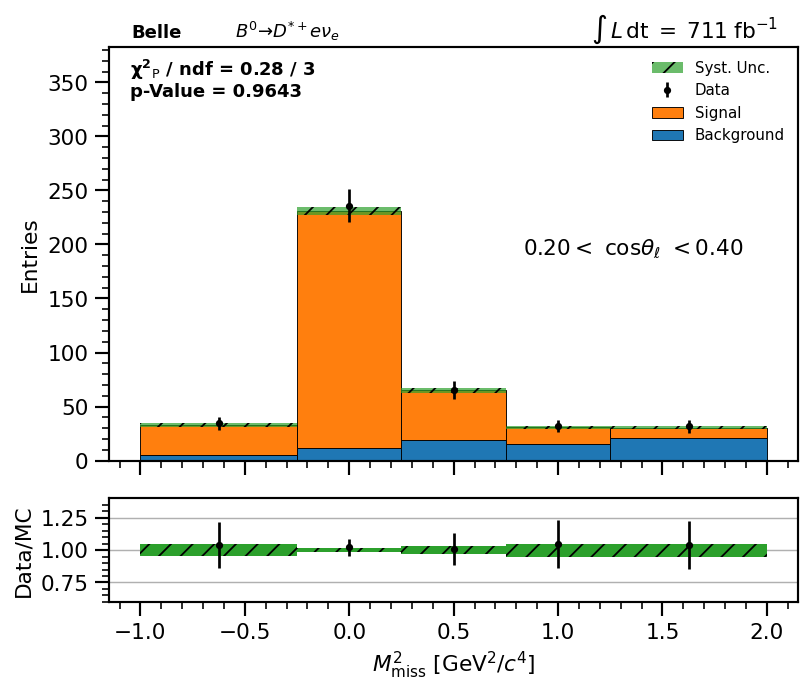

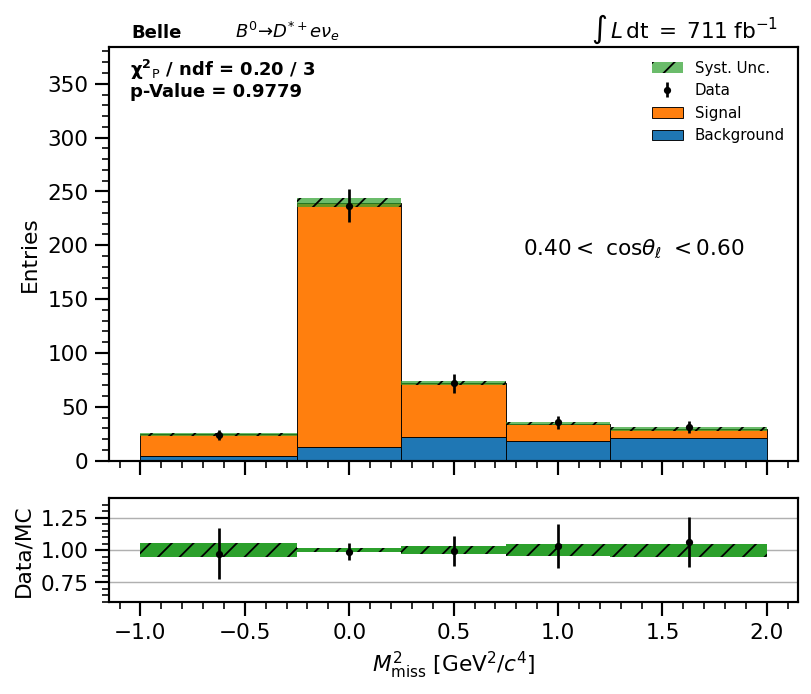

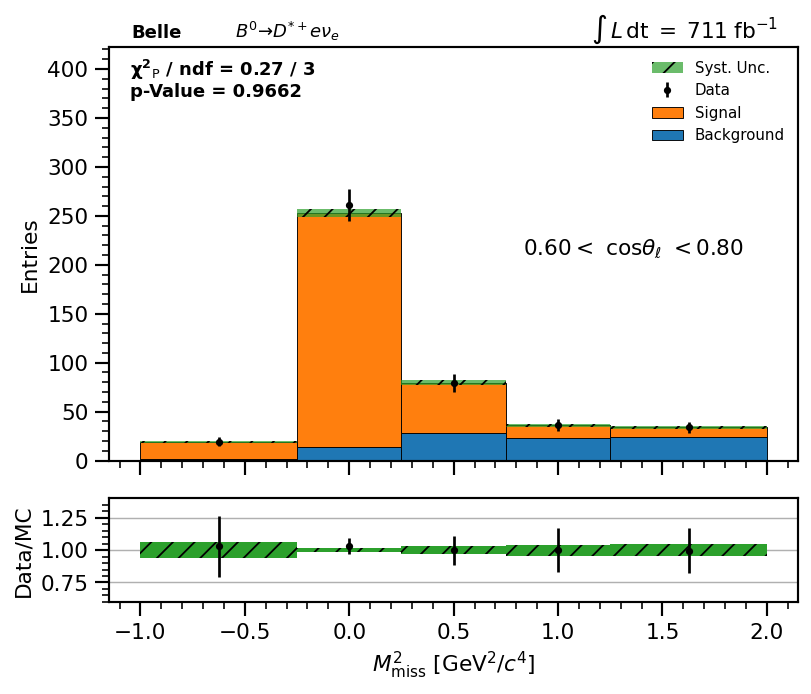

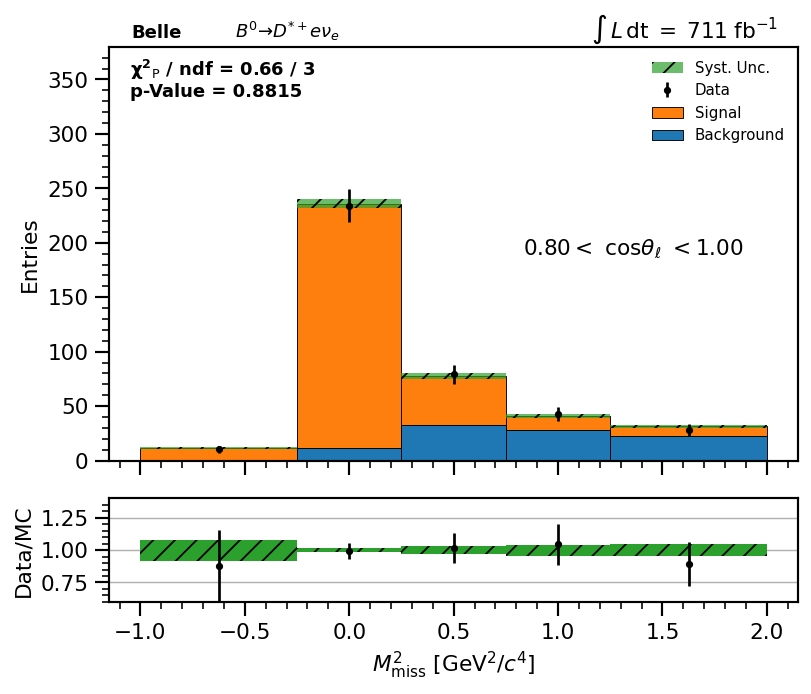

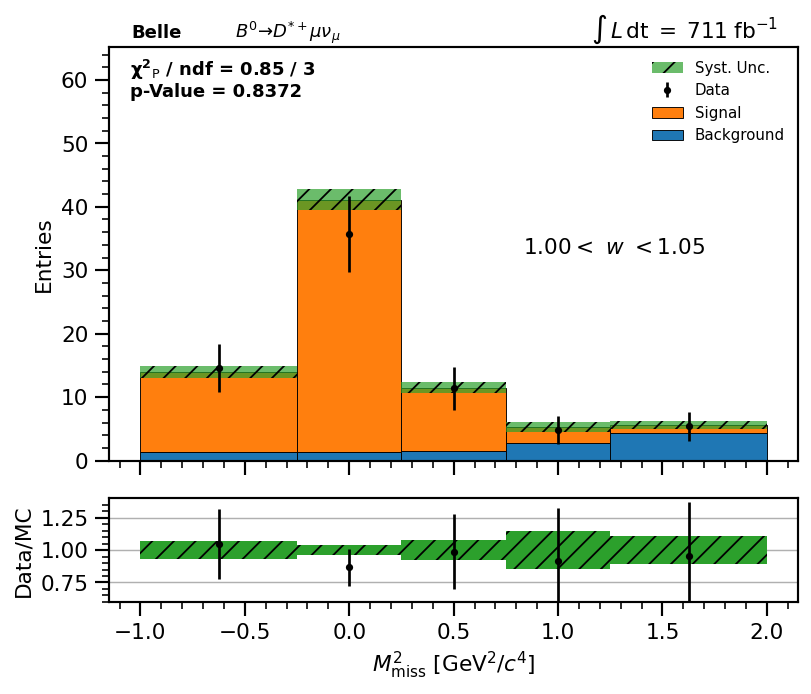

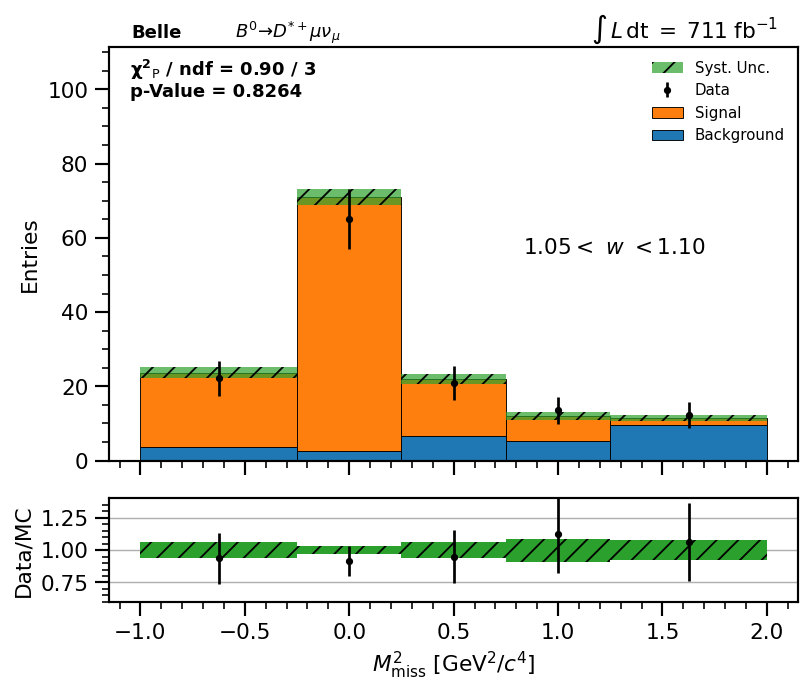

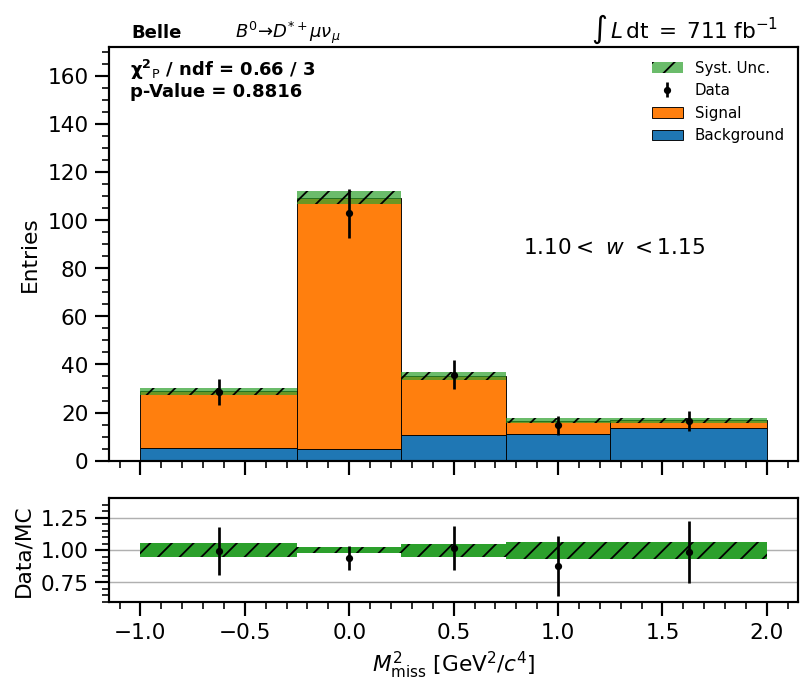

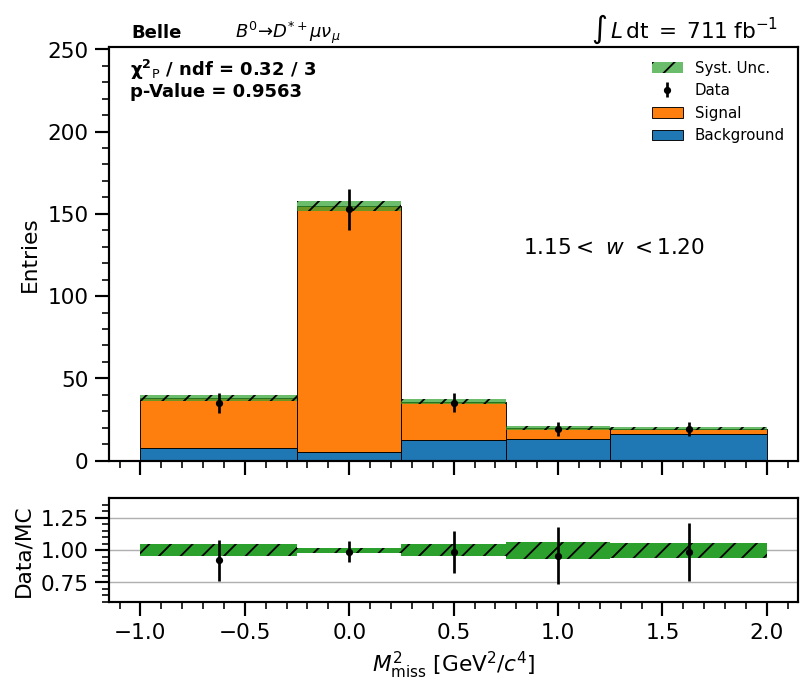

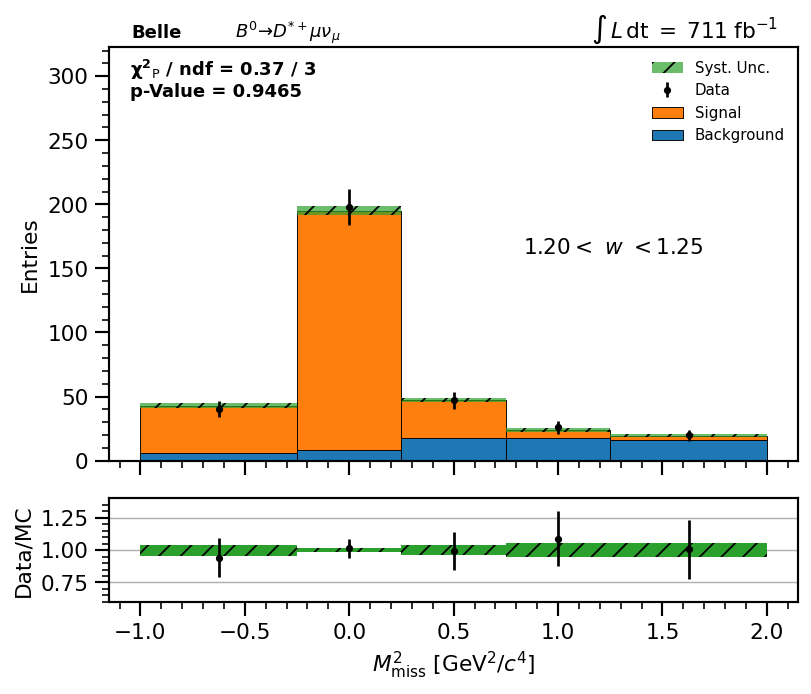

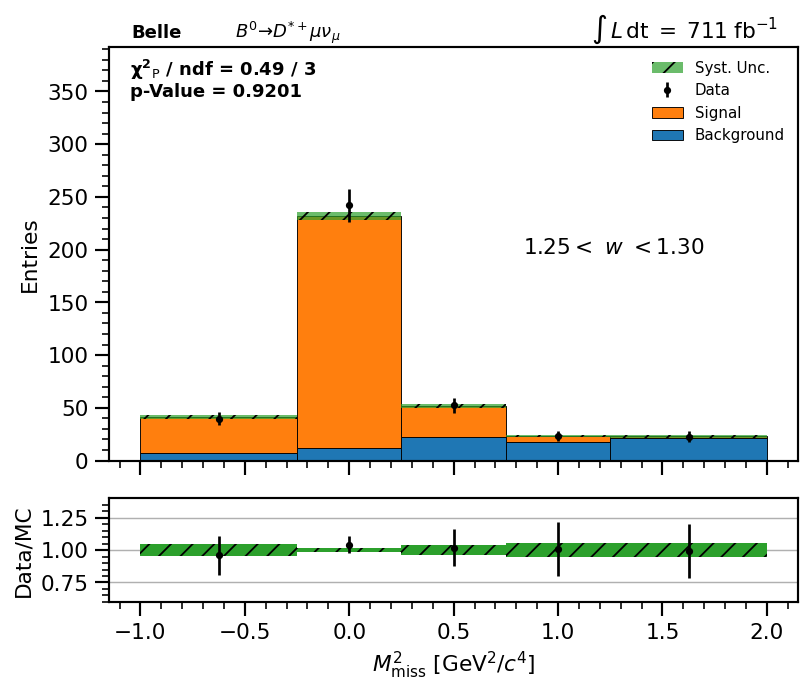

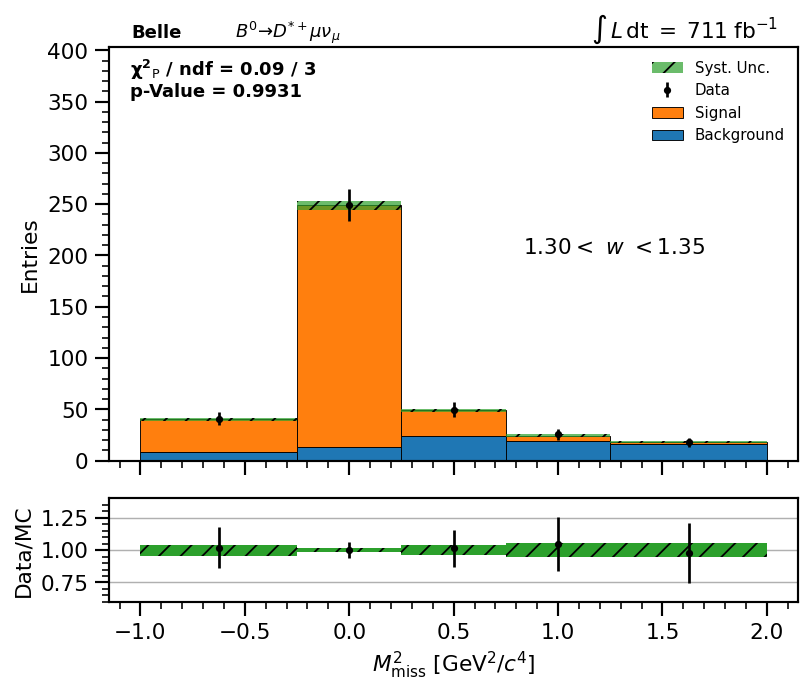

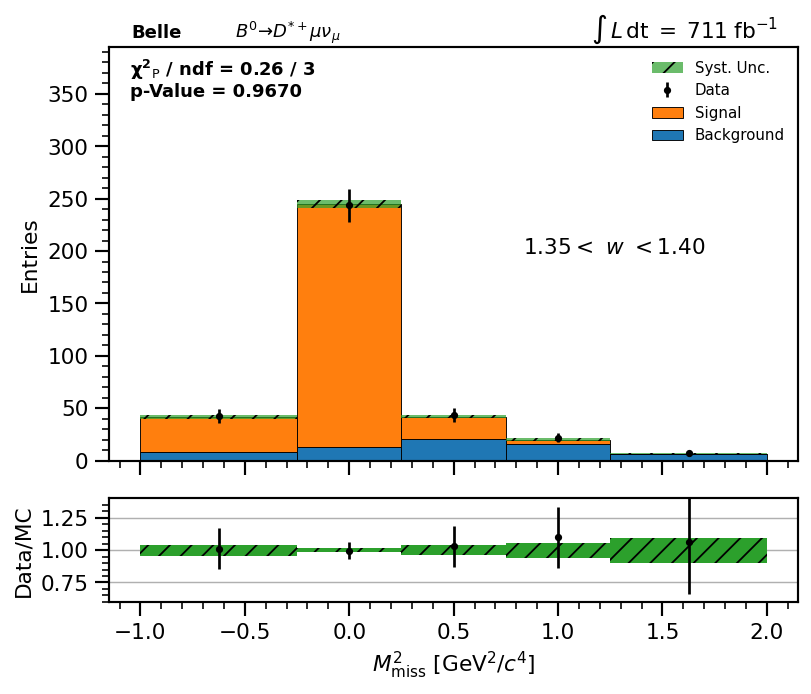

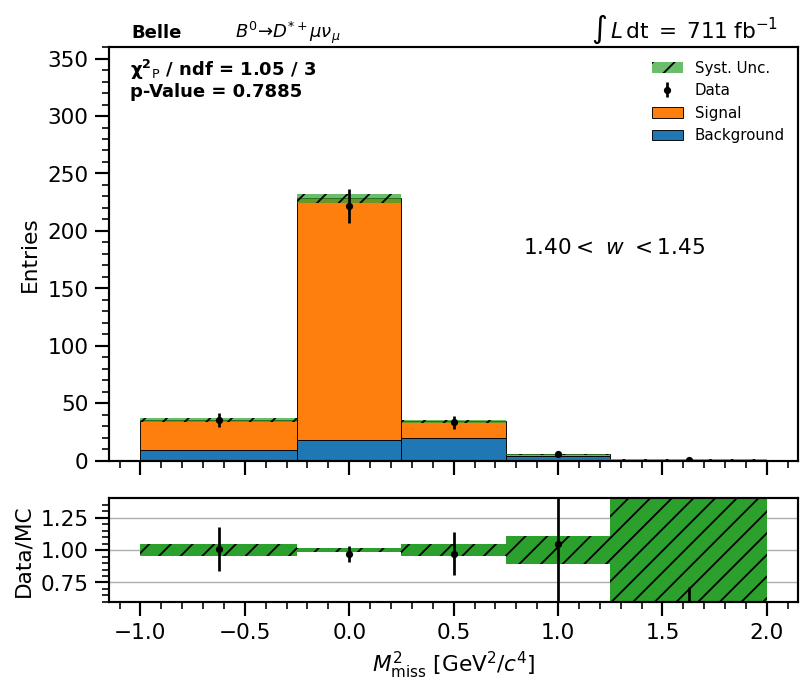

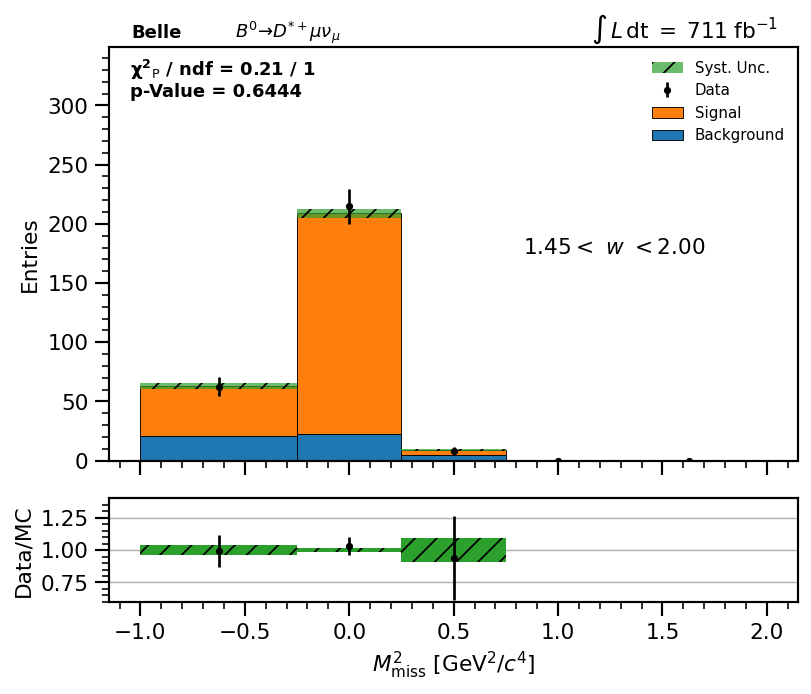

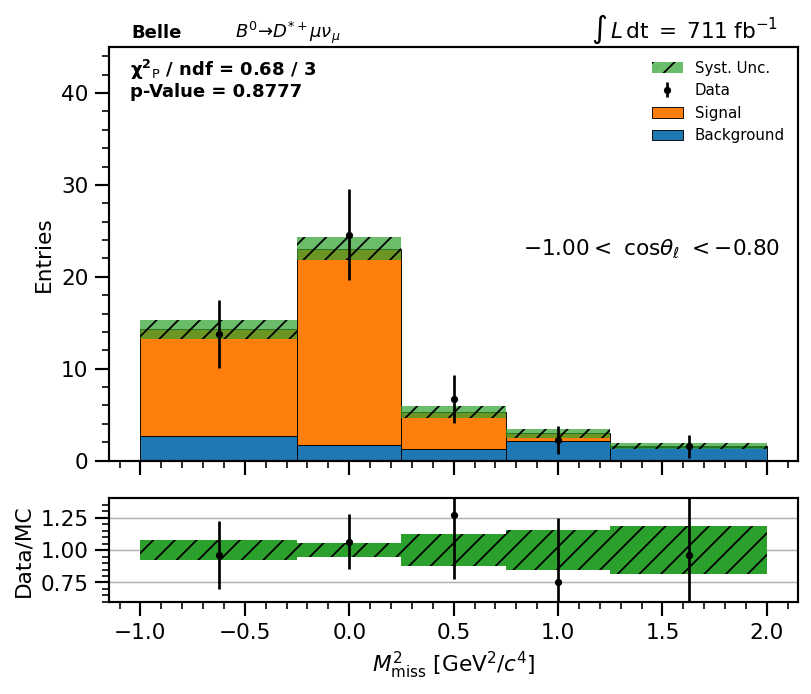

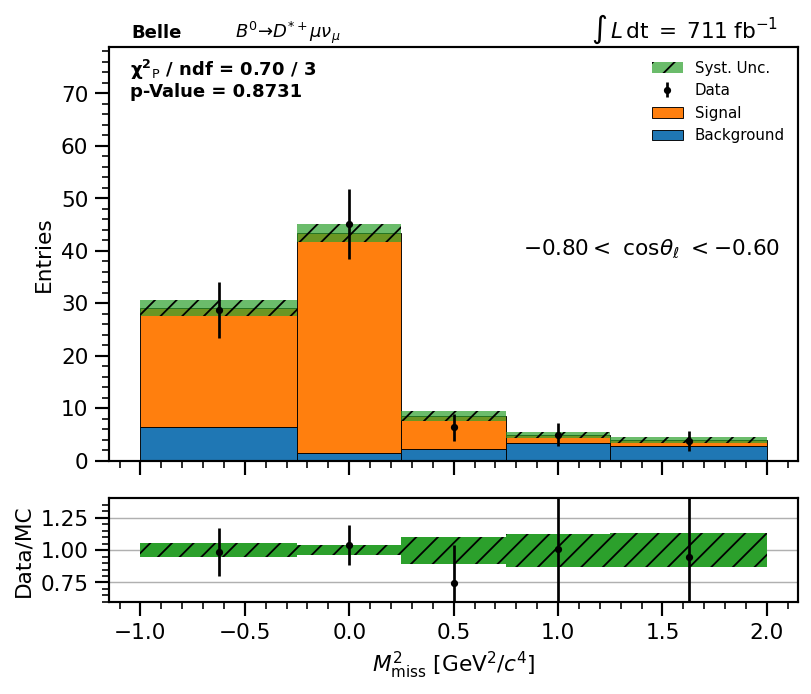

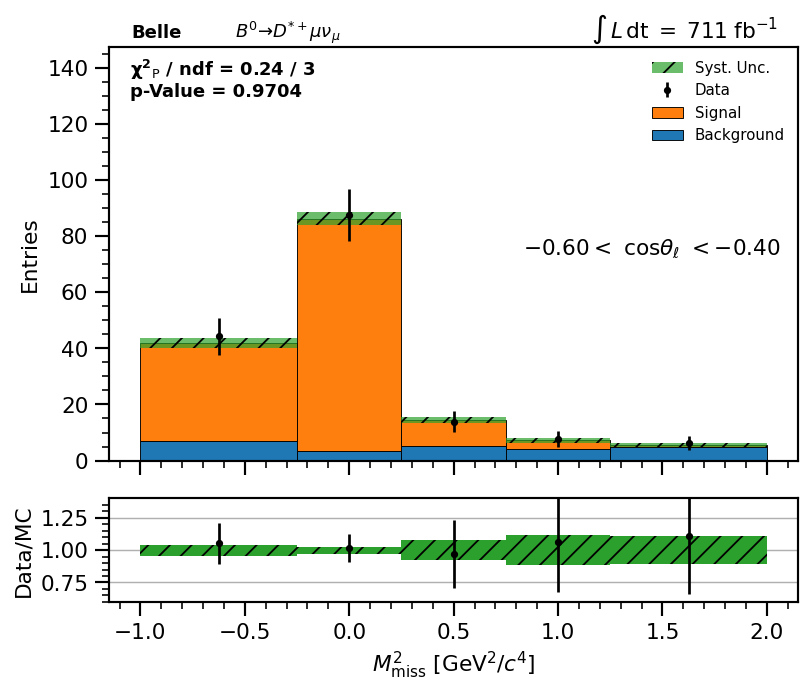

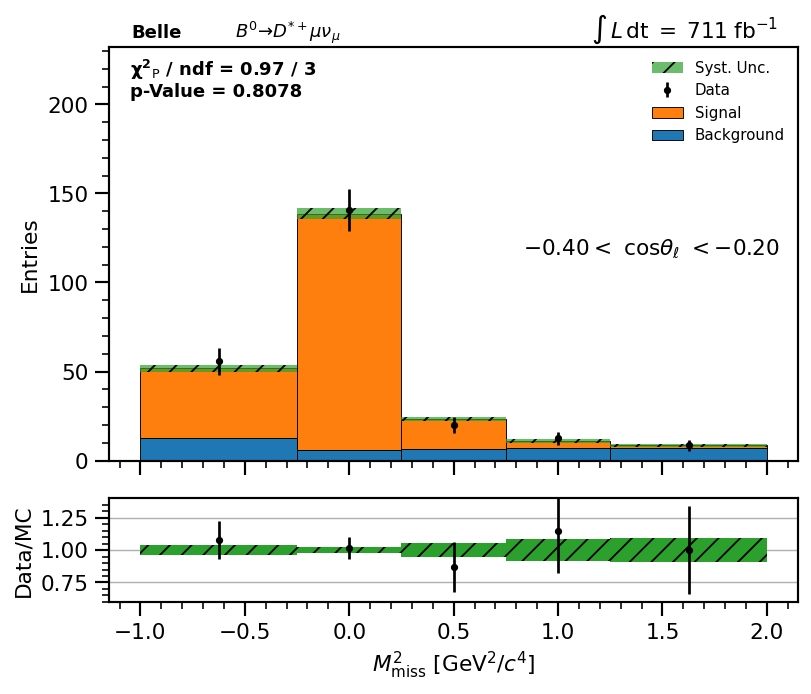

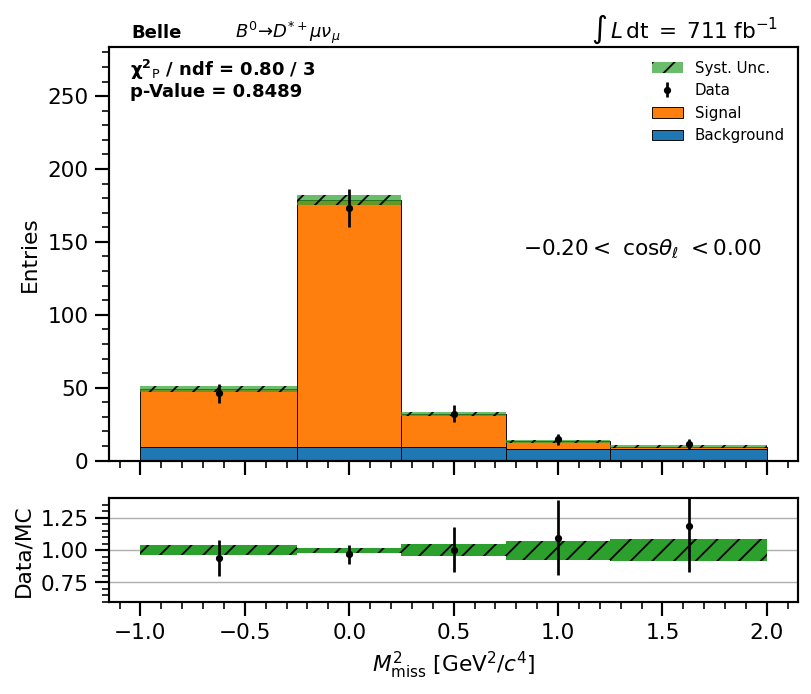

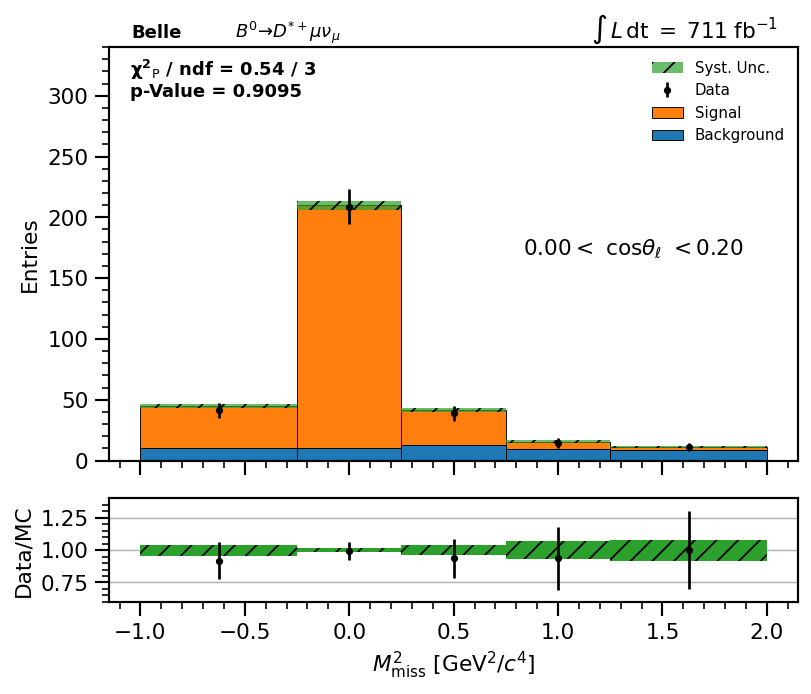

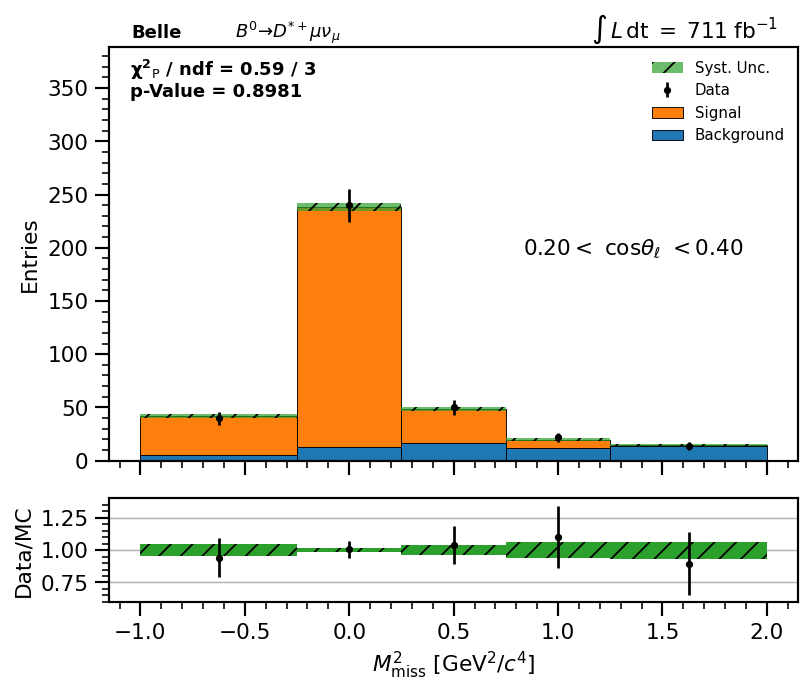

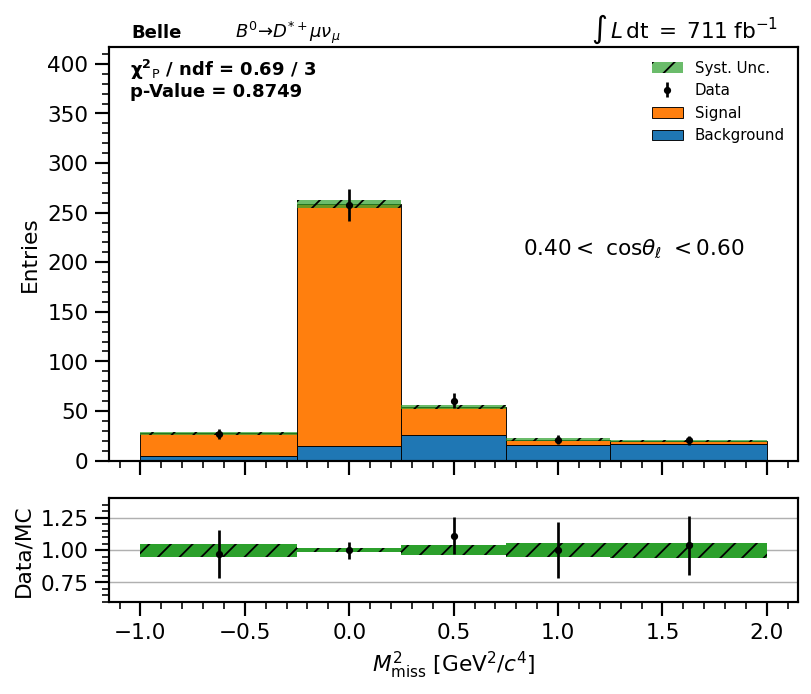

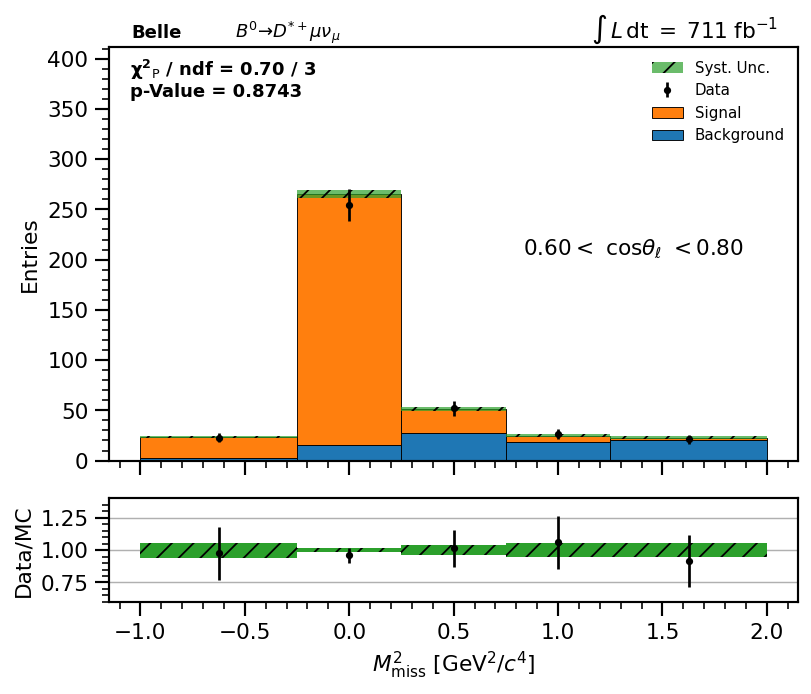

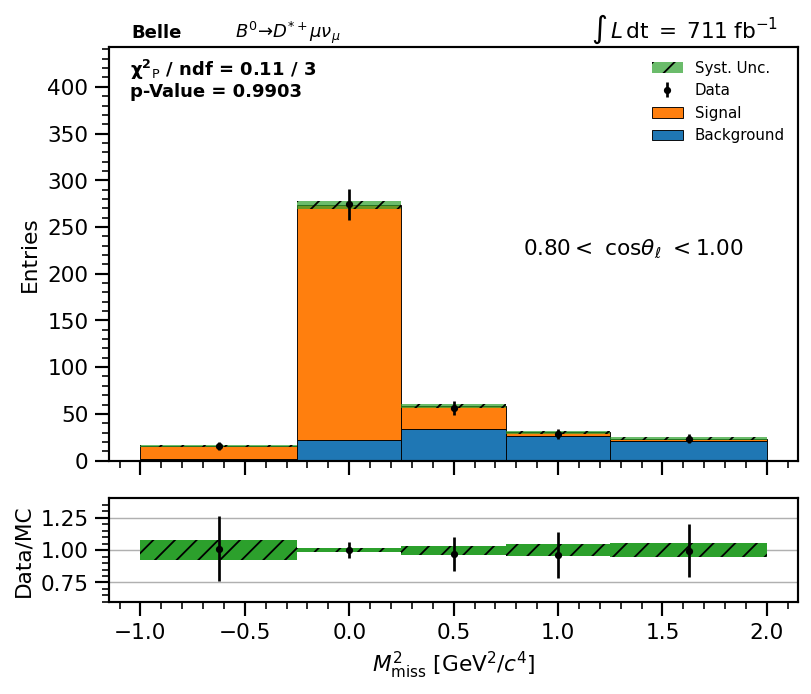

In [35]:
for channel in channels:
    for voi in fit_vois:
        bin_edges = bin_edges_all[voi]
        for i_bin, voi_bin in enumerate(zip(bin_edges, bin_edges[1:])):
            templates = templates_pre_fit[channel][voi][i_bin]
            fig, ax = plot_templates(
                templates=templates,
                template_categories=template_category_names,
                bins=fit_bins,
                var_str=fit_variable_label,
                unit=fit_variable_unit,
                y_str="Entries",
                data=data_type,
                color_dict=color_dict,
                label_dict=label_dict,
                full_systematic_covariance=full_covariance_for_plotting[channel][voi][i_bin],
            )

            add_lumi(ax[0], 711)
            add_watermark(ax[0], channel_label[channel], fontsize=10)
            add_channel(ax[0], f"${voi_bin[0]:.2f} <$ " + r"{}".format(voi_labels[voi]) + f" $< {voi_bin[1]:.2f}$", px=0.6, py=0.5)
            annotate_gof(ax, templates, len(fit_bins) - 1 - len(template_categories), option=data_type)
            plt.tight_layout()
            plt.savefig(f"{plotoutdir}/prefit_channel{channel}_{fit_variable}_{voi}_{i_bin}.pdf", transparent=True)
            plt.savefig(f"{plotoutdir}/prefit_channel{channel}_{fit_variable}_{voi}_{i_bin}.png", transparent=True) 
            plt.show()
            plt.close()
        

### Statistical only fit

In [36]:
fit_results = {}

fit_options = {
    "options": {"maxiter": 200, "disp": False},   
}

for channel in tqdm(channels):
    fit_results[channel] = {}
    for voi in fit_vois:
        bin_edges = bin_edges_all[voi]
        fit_results[channel][voi] = {}        
        for i_bin, _ in enumerate(zip(bin_edges, bin_edges[1:])):
            fit_result = run_fit(L, templates_pre_fit[channel][voi][i_bin], data_type, template_categories, **fit_options)
            fit_results[channel][voi][i_bin] = fit_result
            if fit_result.status:
                print(f"{channel}_n/a_{i_bin}_{fit_result.message}")
            if np.isnan(fit_result.covariance).any():
                print(f"{channel}_n/a_{i_bin}_Hesse determination failed.")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.22s/it]


### Statistical + Systematics fits

Fit with uncorrelated systematics

In [37]:
fit_results_with_uncorrelated_systematics = {}

fit_options = {
    "options": {"maxiter": 200, "disp": False},   
}

for channel in tqdm(channels):
    fit_results_with_uncorrelated_systematics[channel] = {}
    for voi in fit_vois:
        bin_edges = bin_edges_all[voi]
        fit_results_with_uncorrelated_systematics[channel][voi] = {}
        
        for i_bin, _ in enumerate(zip(bin_edges, bin_edges[1:])):
            def Lwrapper(sample, *pars):
                return Lsys(sample, [uncorrelated_systematics[channel][voi][i_bin]["signal"], uncorrelated_systematics[channel][voi][i_bin]["background"]], *pars)
            x0nuisance = unp.uarray(np.zeros(2*(len(fit_bins)-1)), np.ones(2*(len(fit_bins)-1)))
            
            fit_result = run_fit(Lwrapper, templates_pre_fit[channel][voi][i_bin], data_type, template_categories, x0nuisance, **fit_options)
            fit_results_with_uncorrelated_systematics[channel][voi][i_bin] = fit_result
            if fit_result.status:
                print(f"{channel}_n/a_{i_bin}_{fit_result.message}")
            if np.isnan(fit_result.covariance).any():
                print(f"{channel}_n/a_{i_bin}_Hesse determination failed.")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:33<00:00, 46.57s/it]


Fit with all systematics

In [38]:
fit_results_with_systematics = {}

fit_options = {
    "options": {"maxiter": 200, "disp": False},   
}

for channel in tqdm(channels):
    fit_results_with_systematics[channel] = {}
    for voi in fit_vois:
        bin_edges = bin_edges_all[voi]
        fit_results_with_systematics[channel][voi] = {}
        
        for i_bin, _ in enumerate(zip(bin_edges, bin_edges[1:])):
            def Lwrapper(sample, *pars):
                return Lsys(sample, [full_systematics[channel][voi][i_bin]["signal"], full_systematics[channel][voi][i_bin]["background"]], *pars)
            x0nuisance = unp.uarray(np.zeros(2*(len(fit_bins)-1)), np.ones(2*(len(fit_bins)-1)))
            
            fit_result = run_fit(Lwrapper, templates_pre_fit[channel][voi][i_bin], data_type, template_categories, x0nuisance, **fit_options)
            fit_results_with_systematics[channel][voi][i_bin] = fit_result
            if fit_result.status:
                print(f"{channel}_n/a_{i_bin}_{fit_result.message}")
            if np.isnan(fit_result.covariance).any():
                print(f"{channel}_n/a_{i_bin}_Hesse determination failed.")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:33<00:00, 46.55s/it]


### Plot Fit Results

In [39]:
templates_post_fit = {}

signal_nuisance = slice(2, len(fit_bins)+1)
background_nuisance = slice(len(fit_bins)+1, 2*len(fit_bins)+2)

for channel in channels:
    templates_post_fit[channel] = {}
    for voi in fit_vois:
        bin_edges = bin_edges_all[voi]
        templates_post_fit[channel][voi] = {}
    
        for i_bin in range(len(bin_edges)-1):
            templates_post_fit[channel][voi][i_bin] = {}

            for i_yield, category in enumerate(template_categories):
                pre_fit = unp.nominal_values(templates_pre_fit[channel][voi][i_bin][category])
                relative_errors = full_systematics[channel][voi][i_bin][category]["covariance"].diagonal()**0.5 / pre_fit
                relative_errors = np.nan_to_num(relative_errors)
                pull = 1 + fit_results_with_systematics[channel][voi][i_bin].x[signal_nuisance] * relative_errors
                pre_fit_times_pull = (pre_fit * pull)
                fractions = (pre_fit_times_pull) / sum(pre_fit_times_pull)
                
                templates_post_fit[channel][voi][i_bin][category] = fractions * fit_results_with_systematics[channel][voi][i_bin].x[i_yield]
            
            templates_post_fit[channel][voi][i_bin]["data"] = templates_pre_fit[channel][voi][i_bin]["data"]
            templates_post_fit[channel][voi][i_bin]["toy_data"] = templates_pre_fit[channel][voi][i_bin]["toy_data"]
            templates_post_fit[channel][voi][i_bin]["asimov_data"] = templates_pre_fit[channel][voi][i_bin]["asimov_data"]

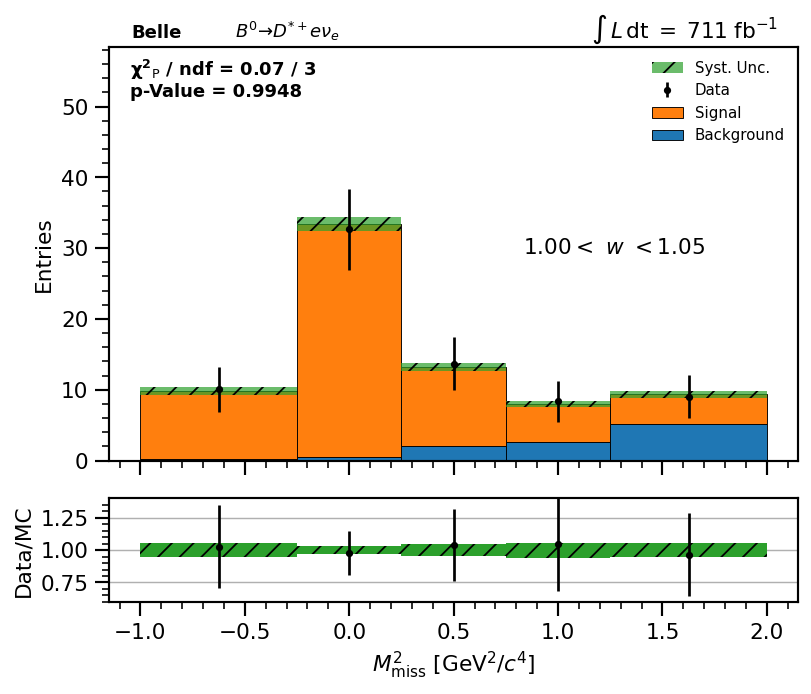

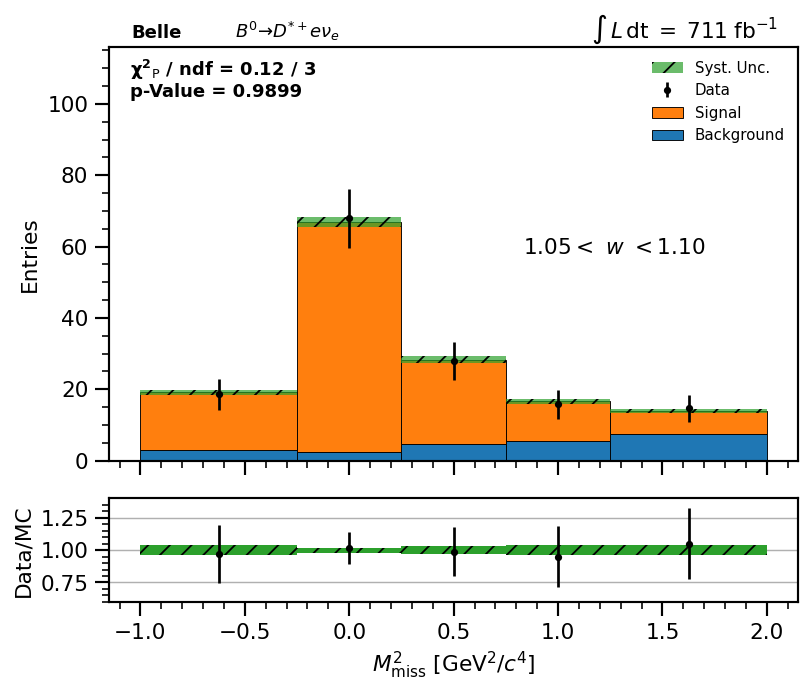

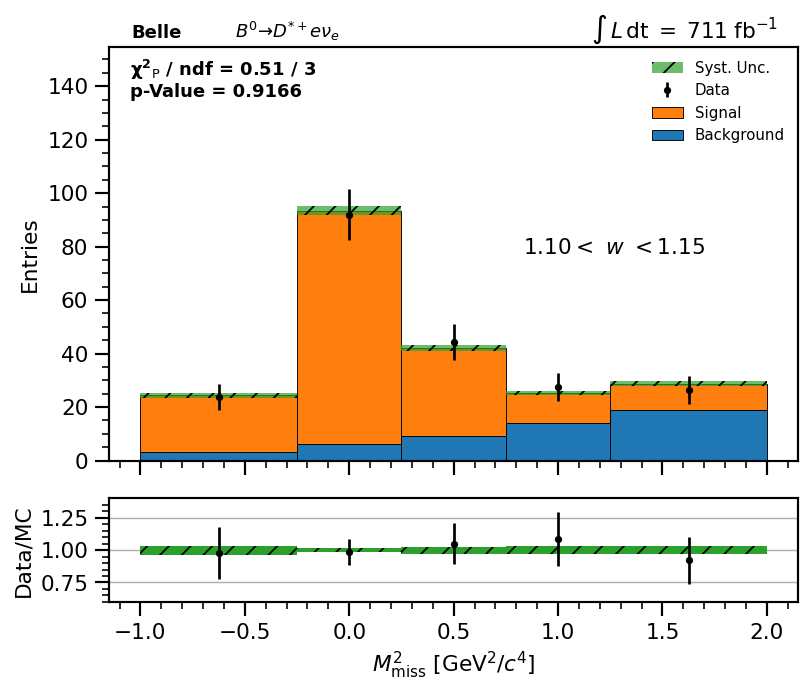

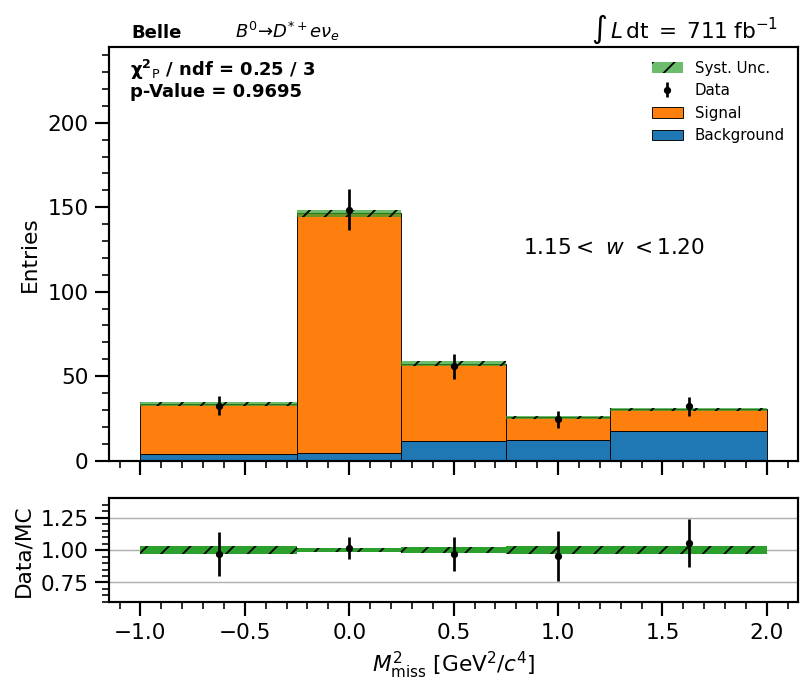

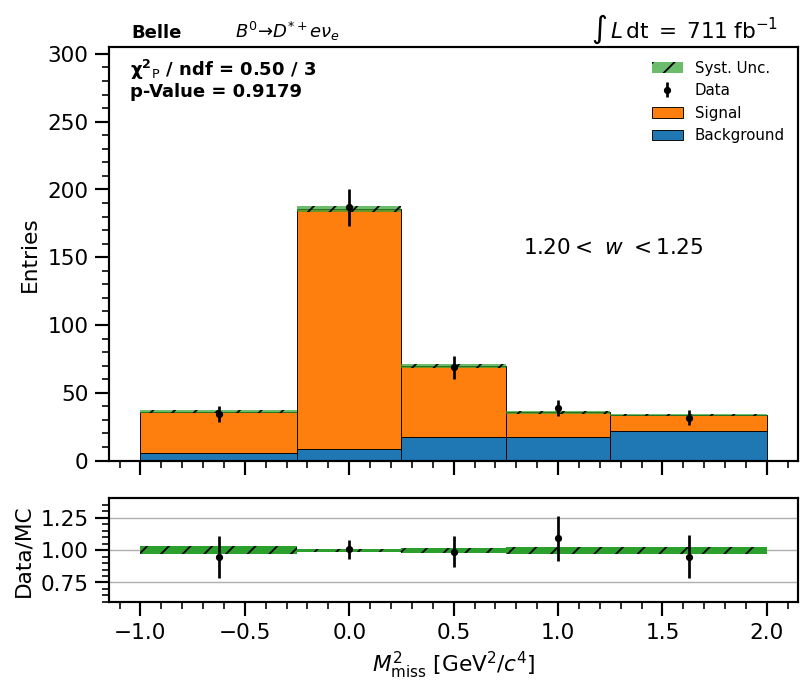

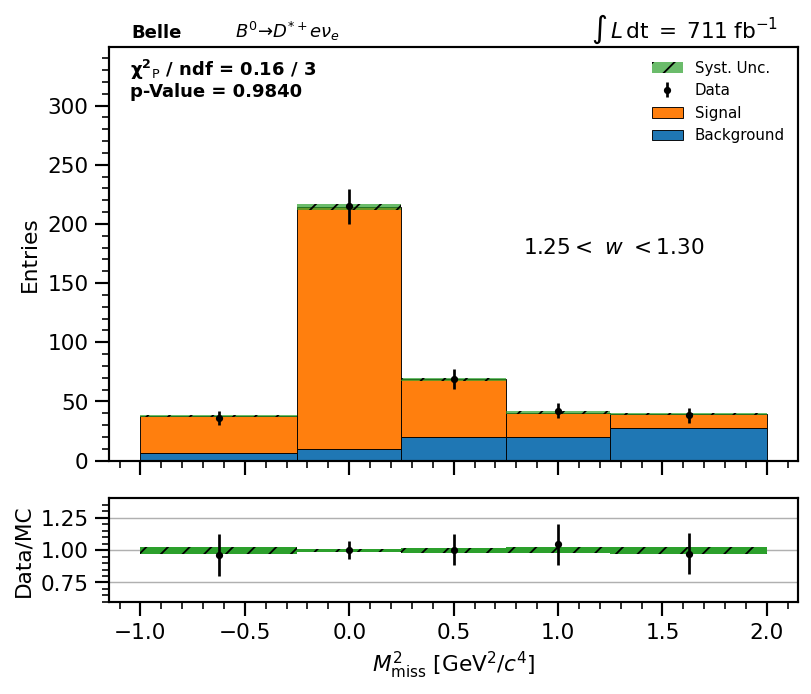

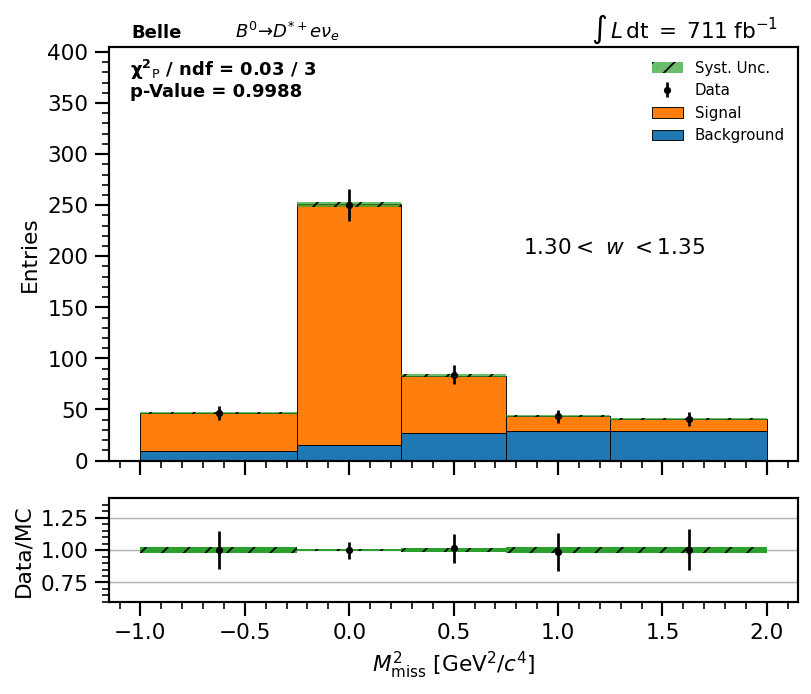

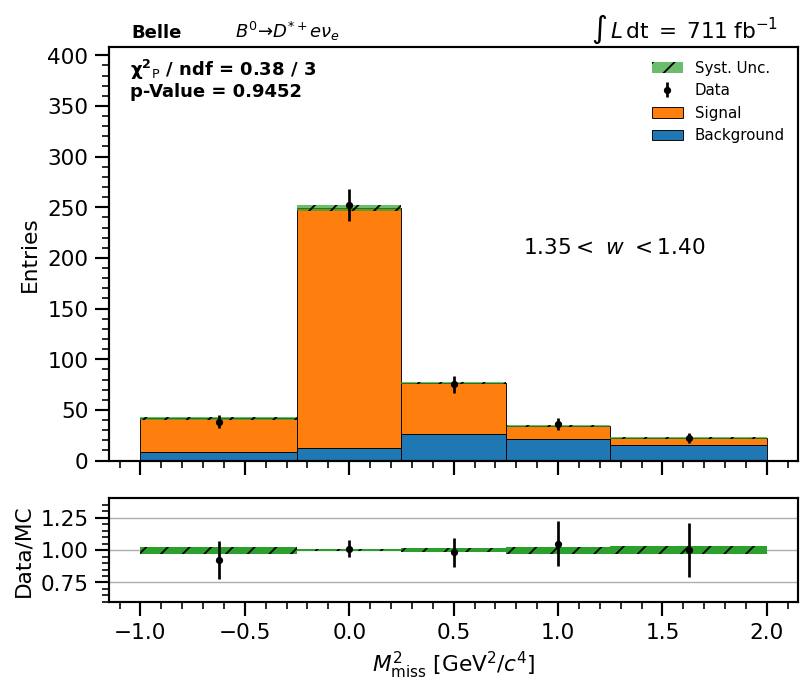

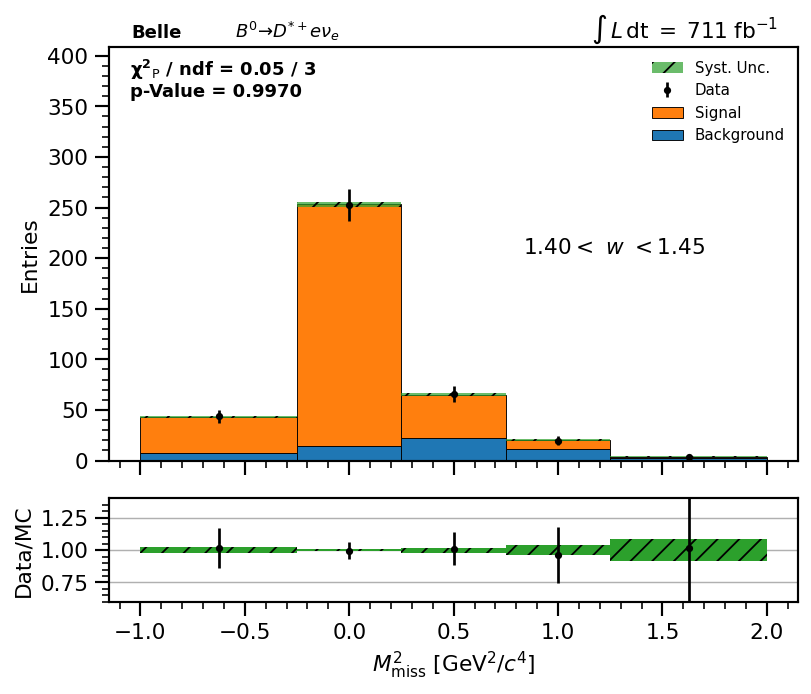

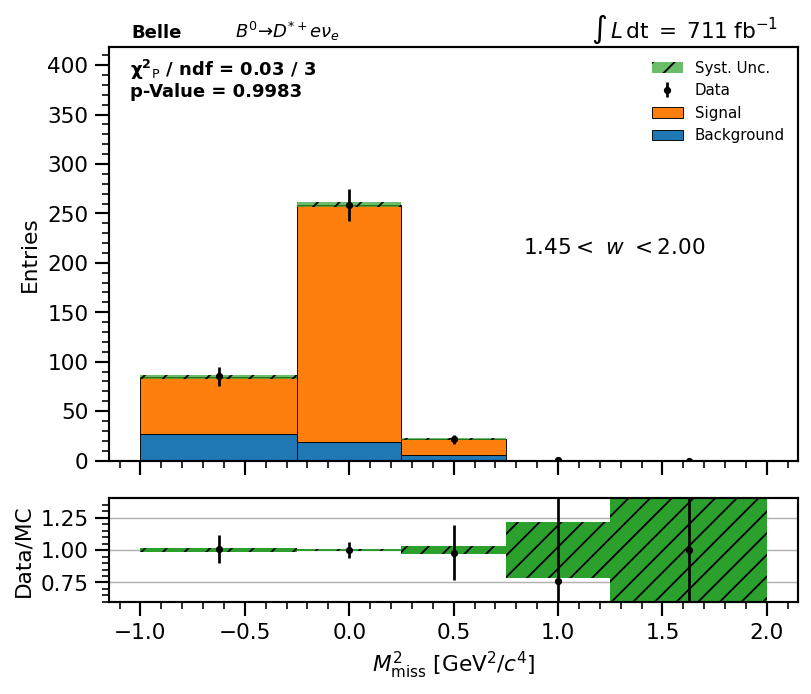

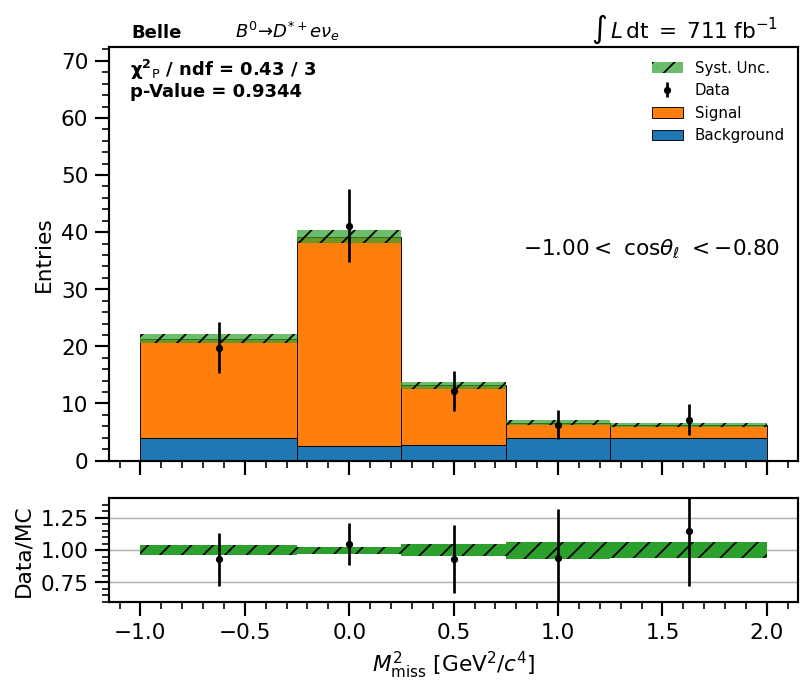

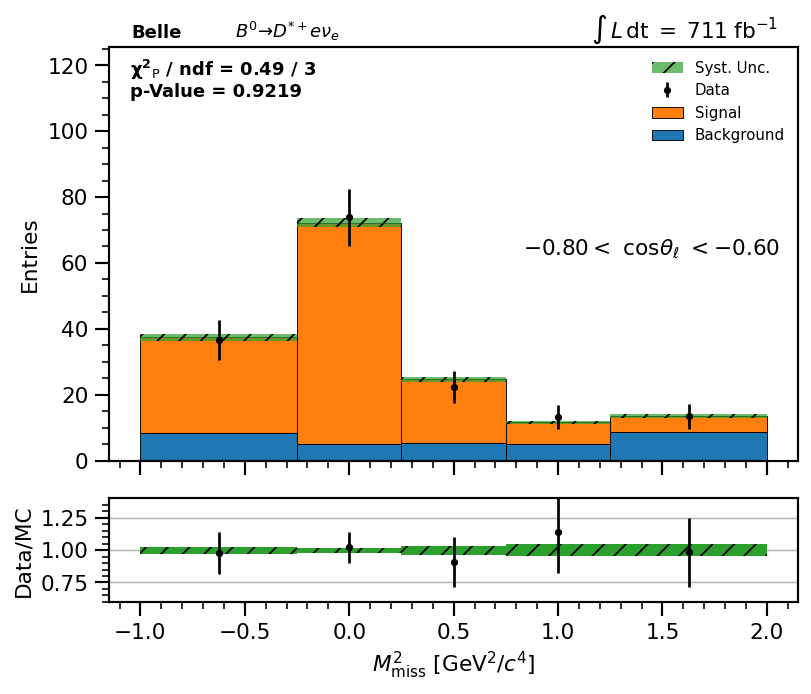

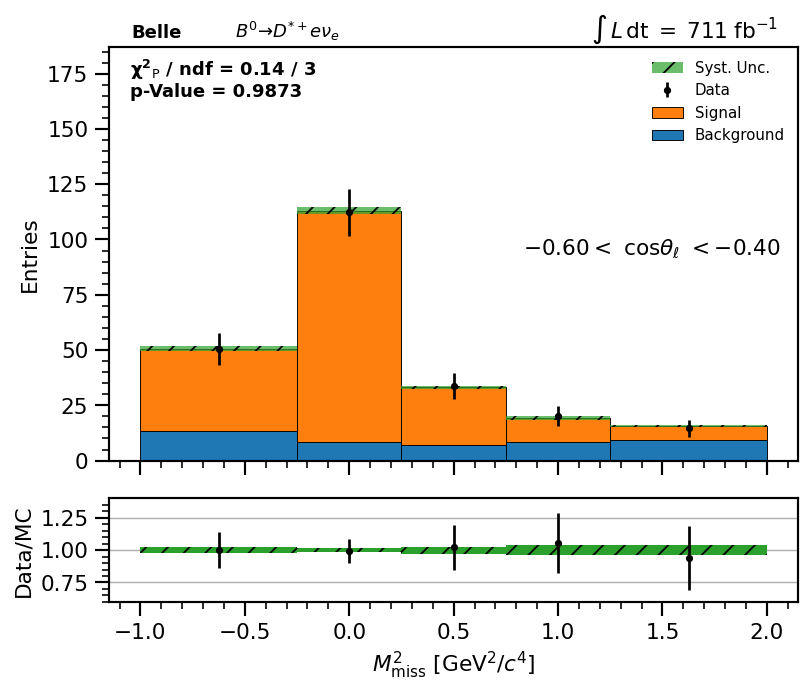

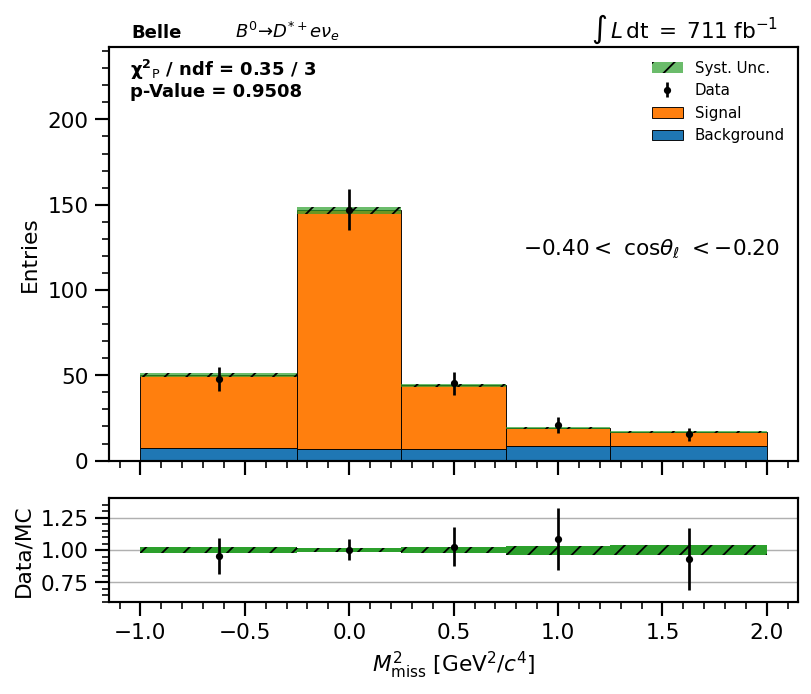

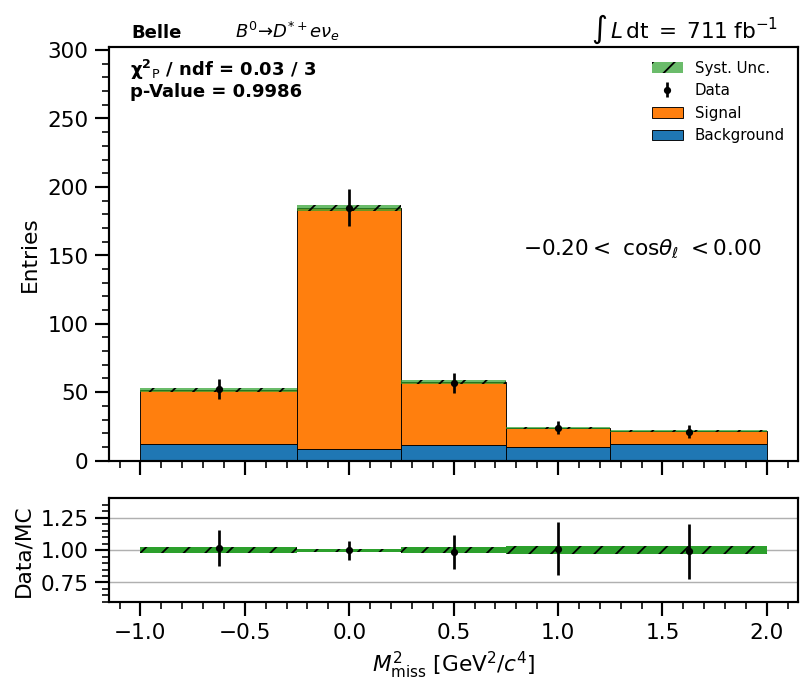

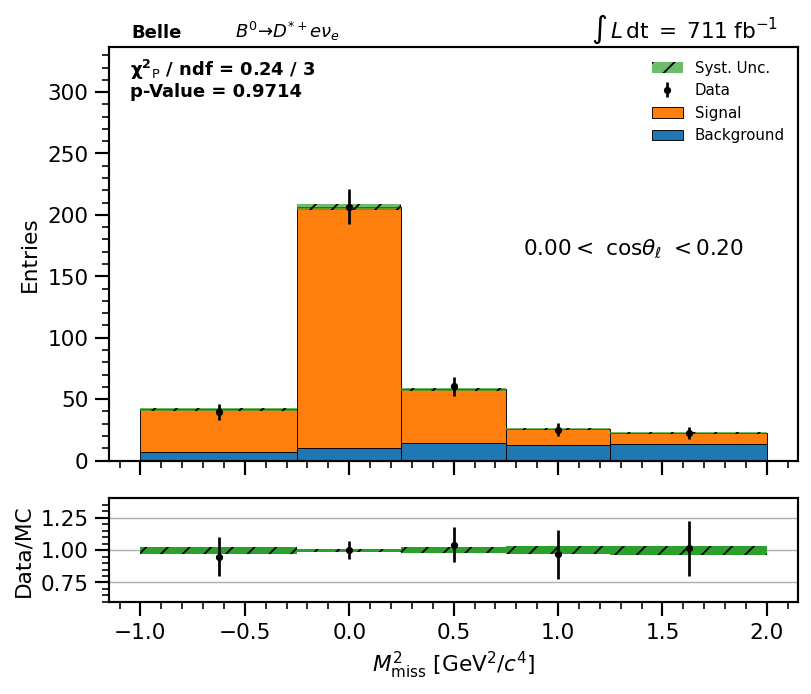

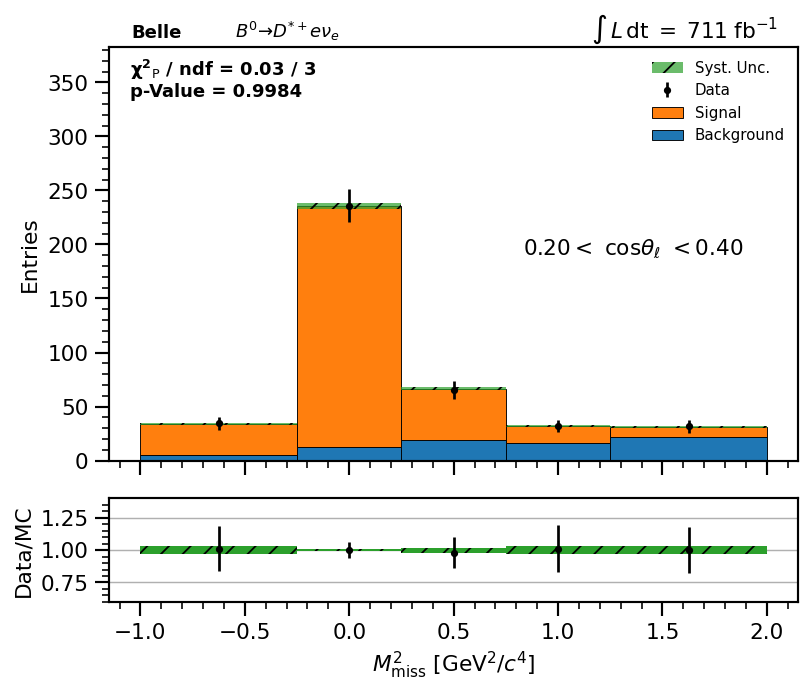

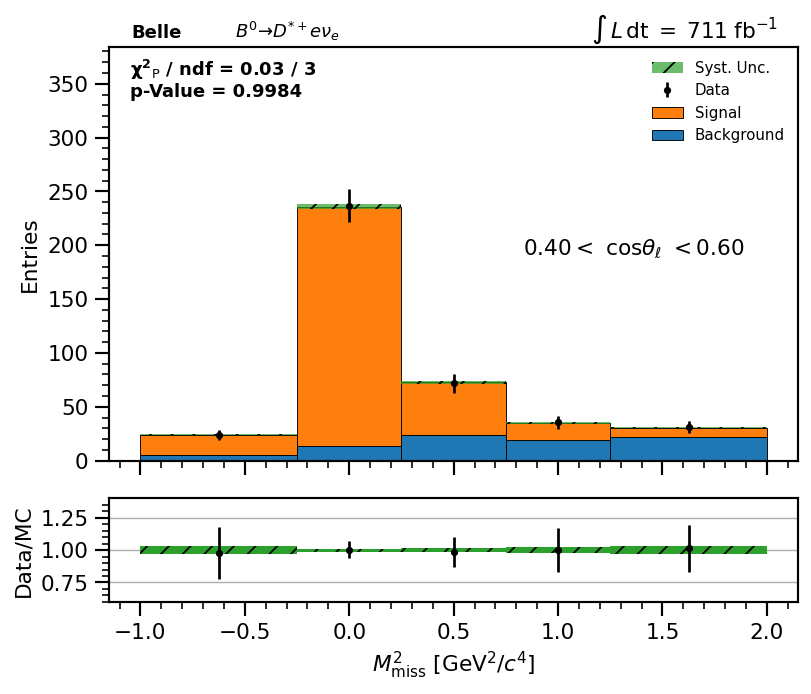

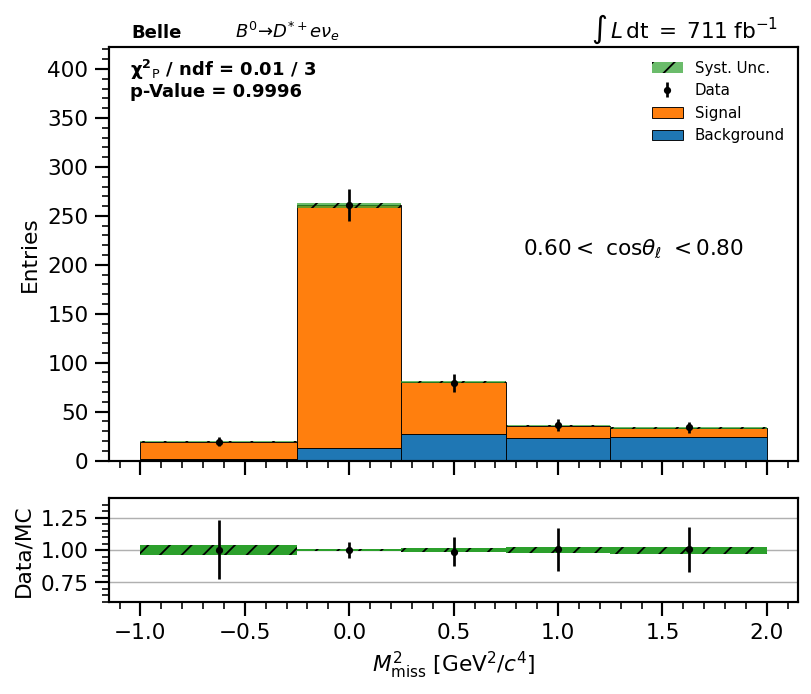

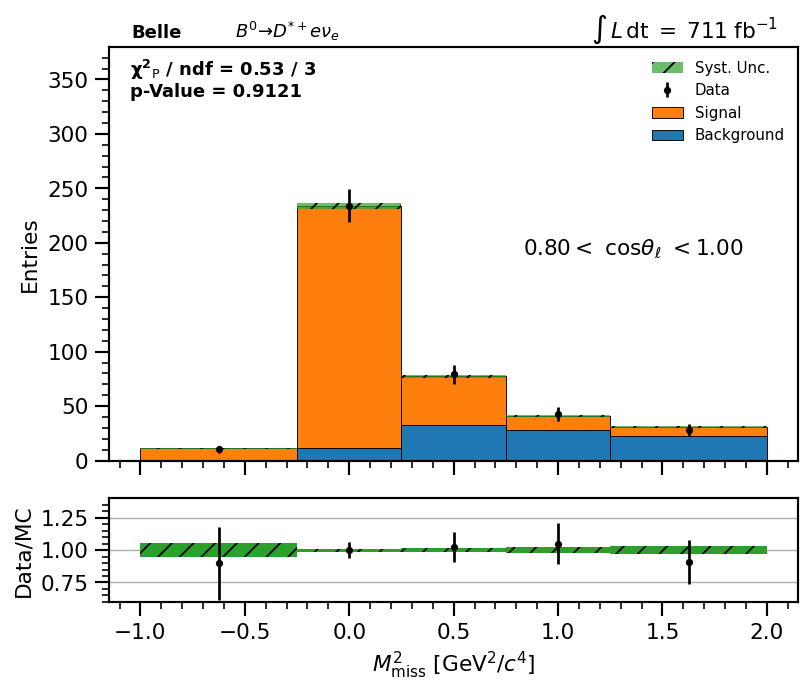

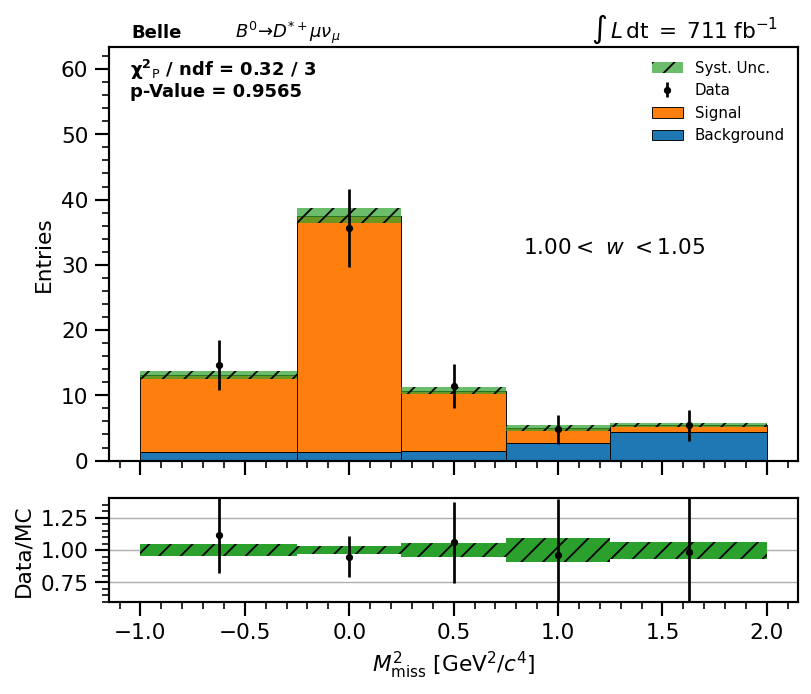

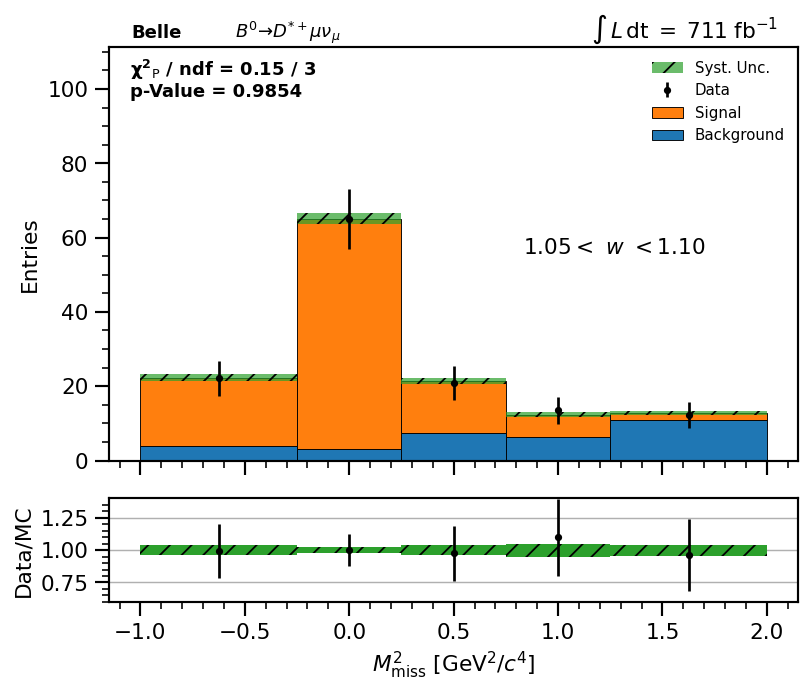

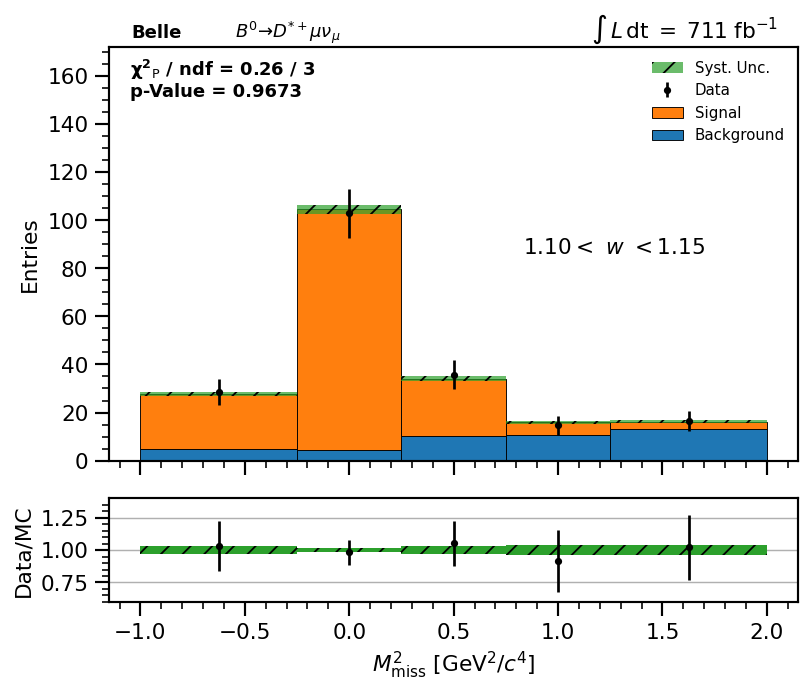

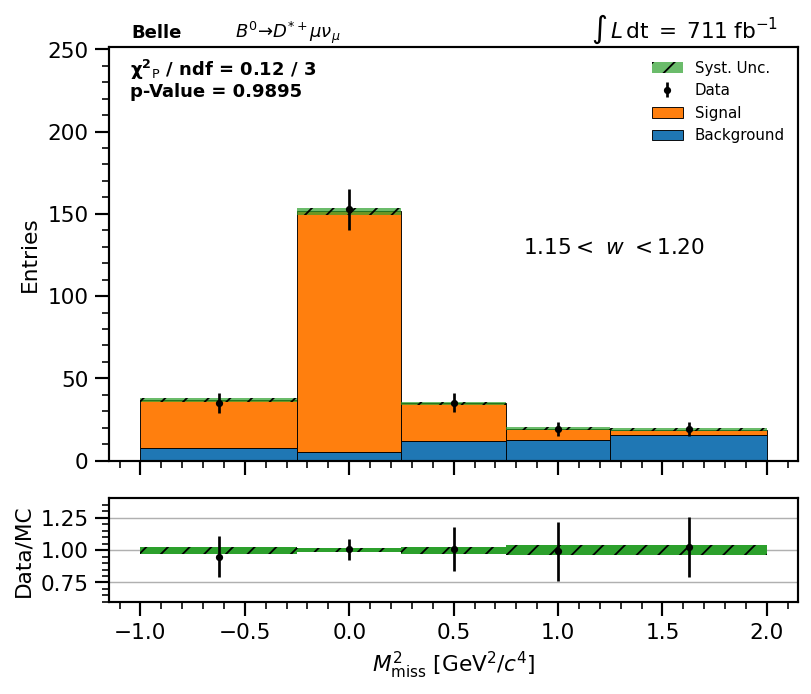

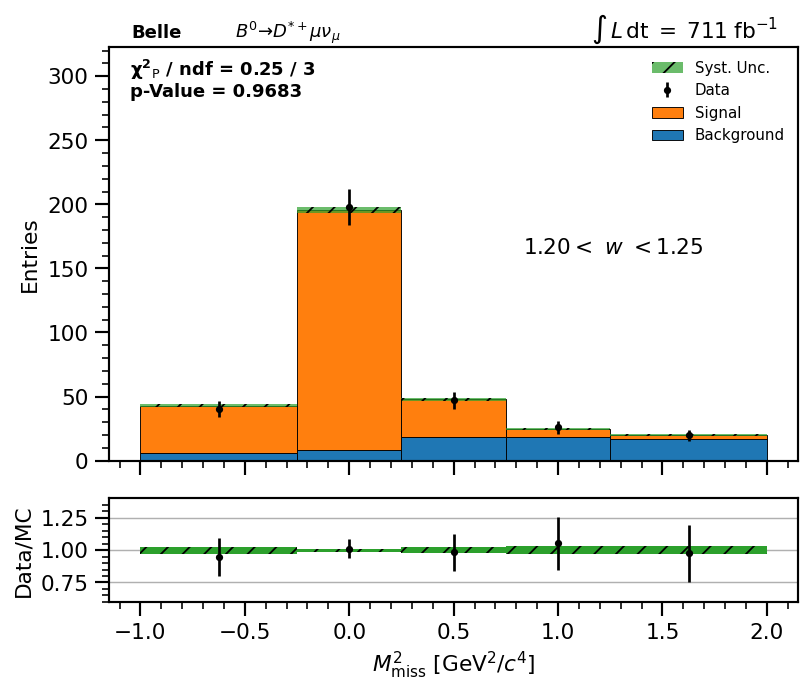

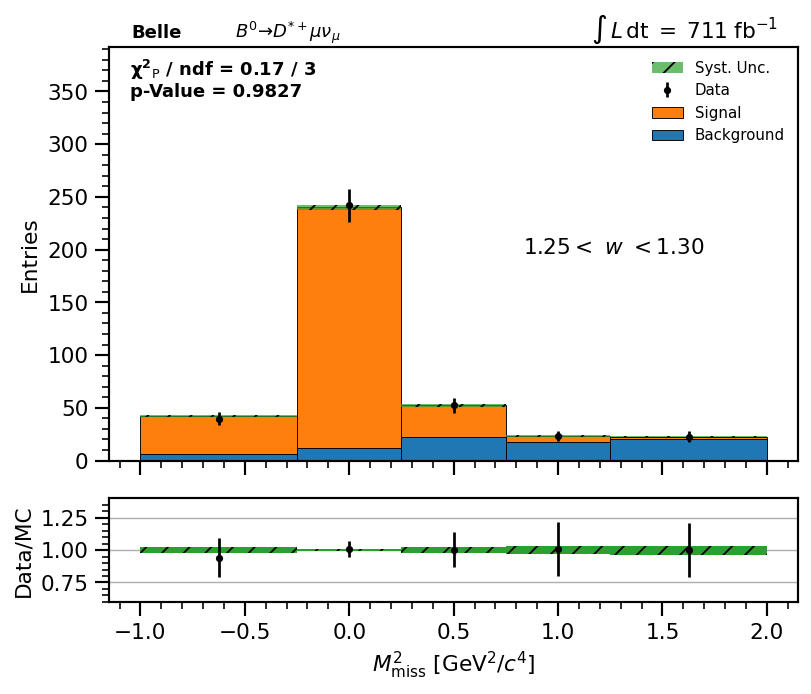

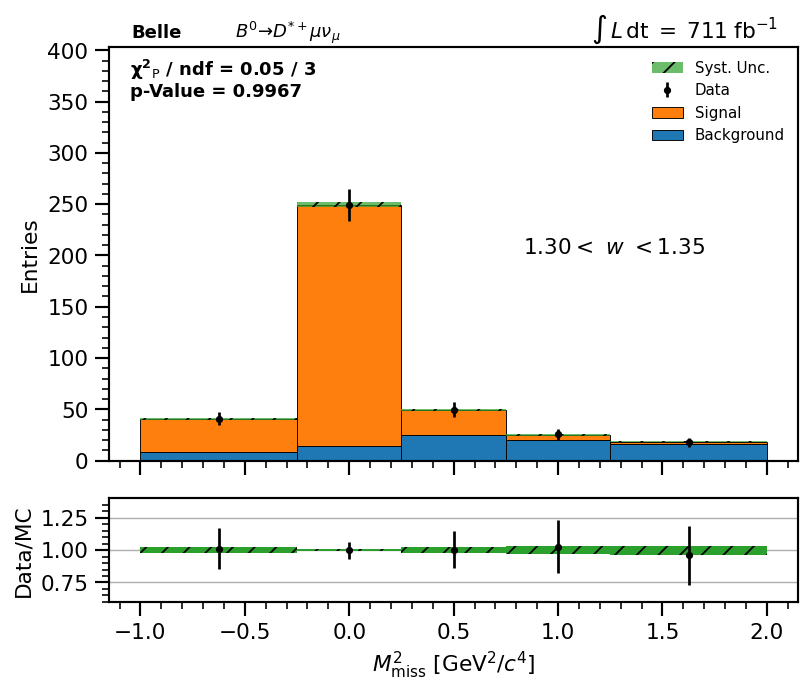

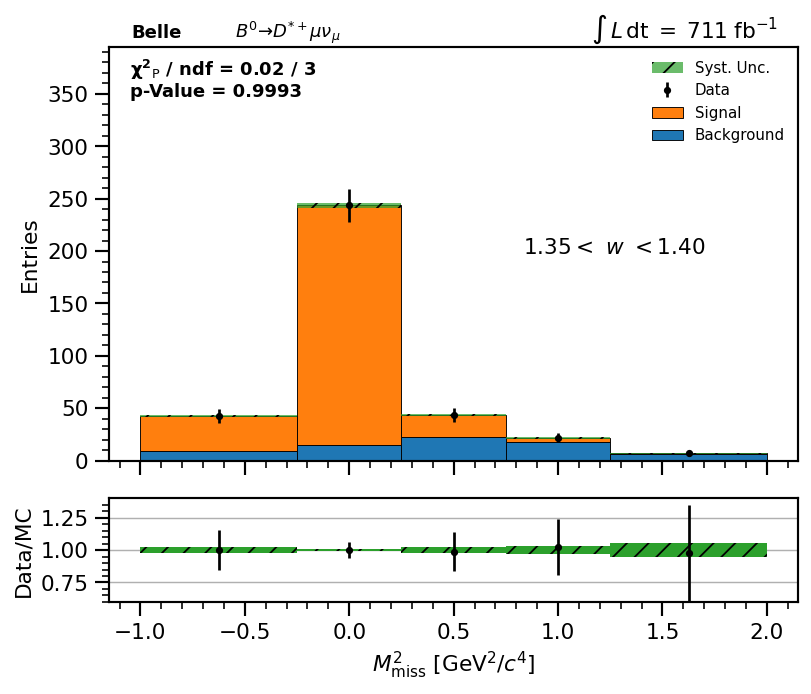

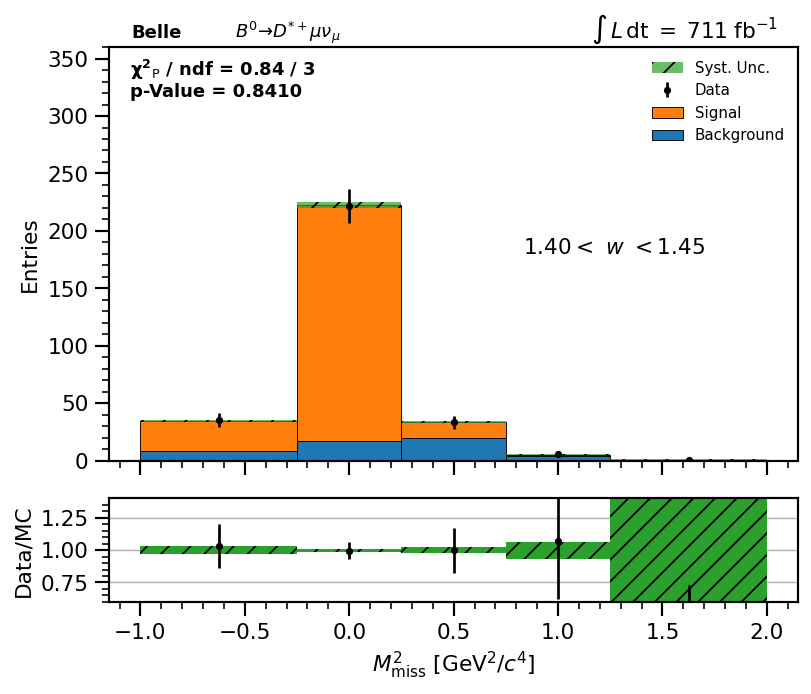

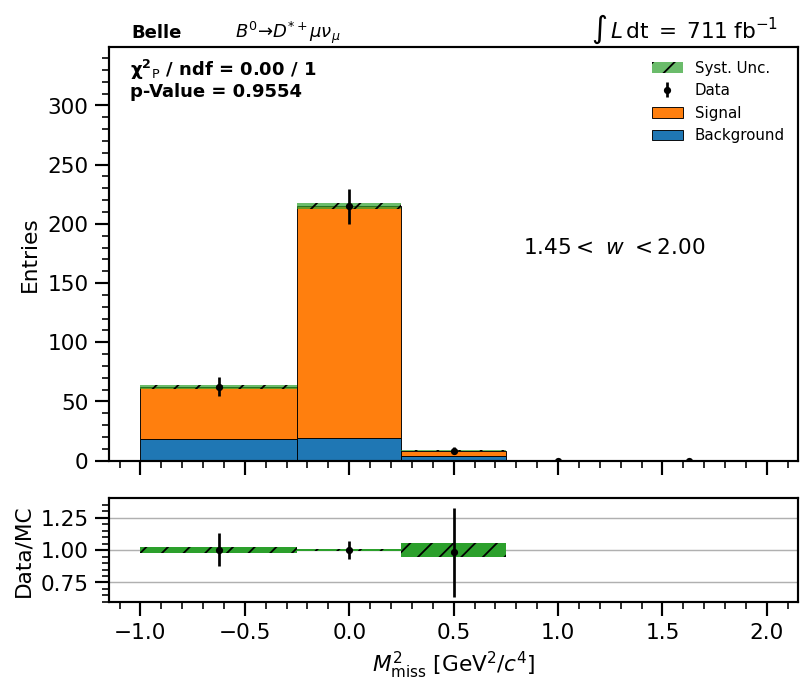

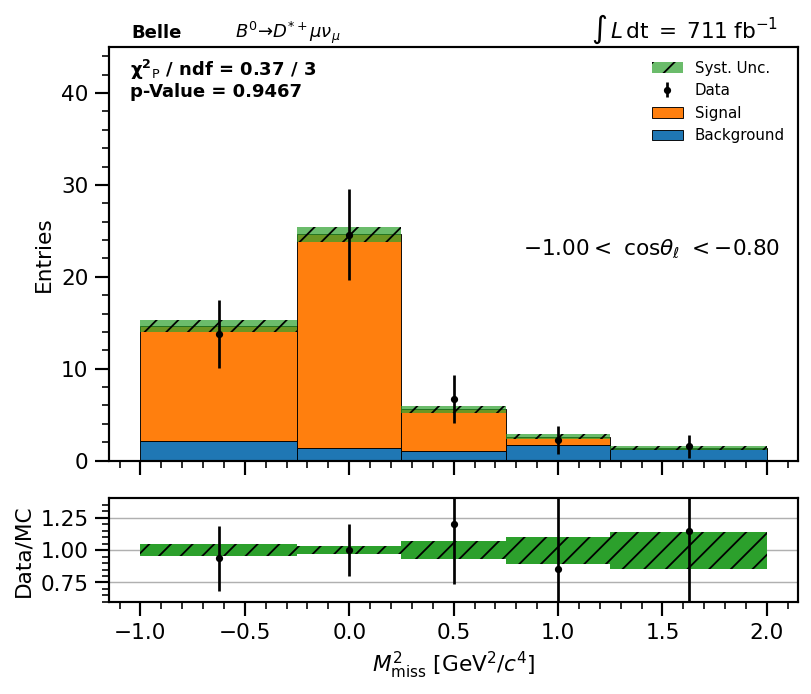

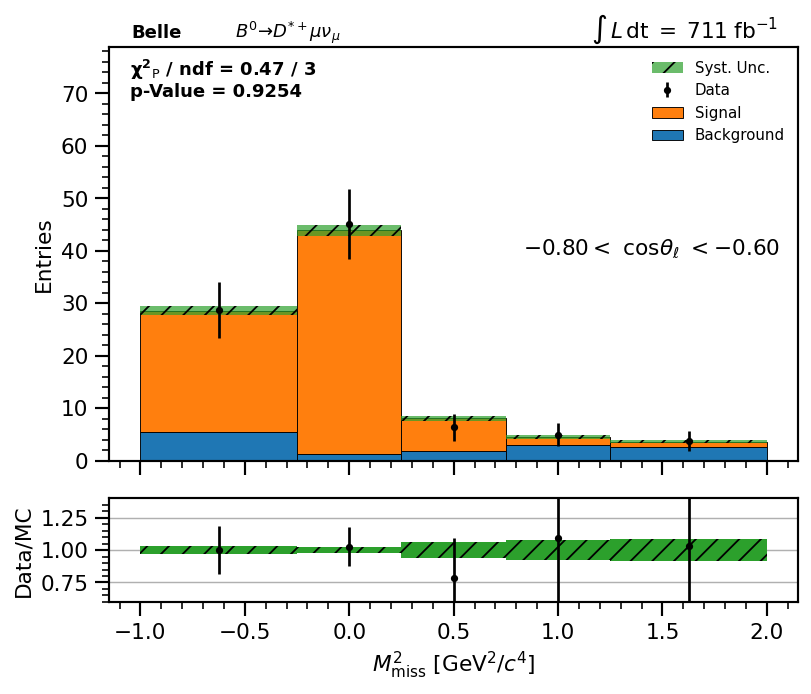

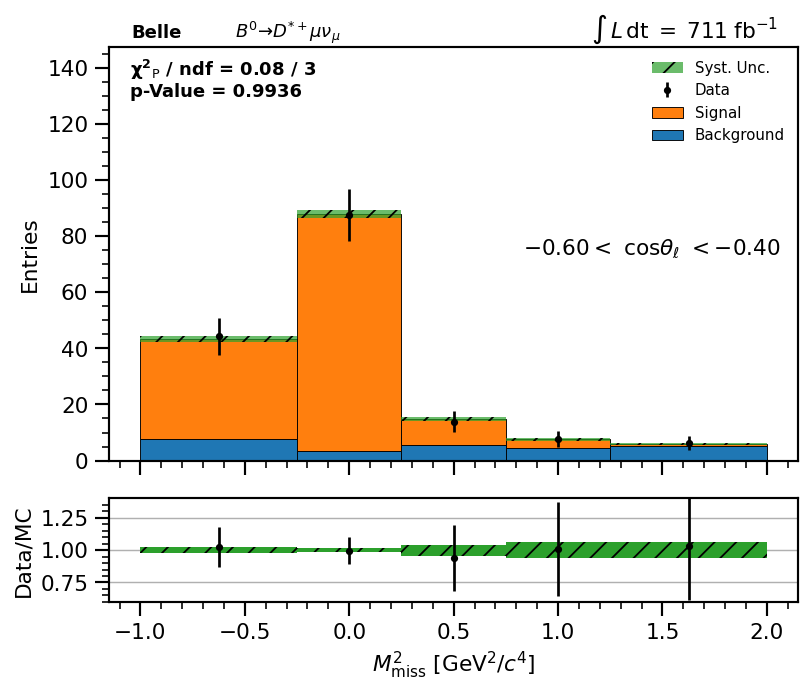

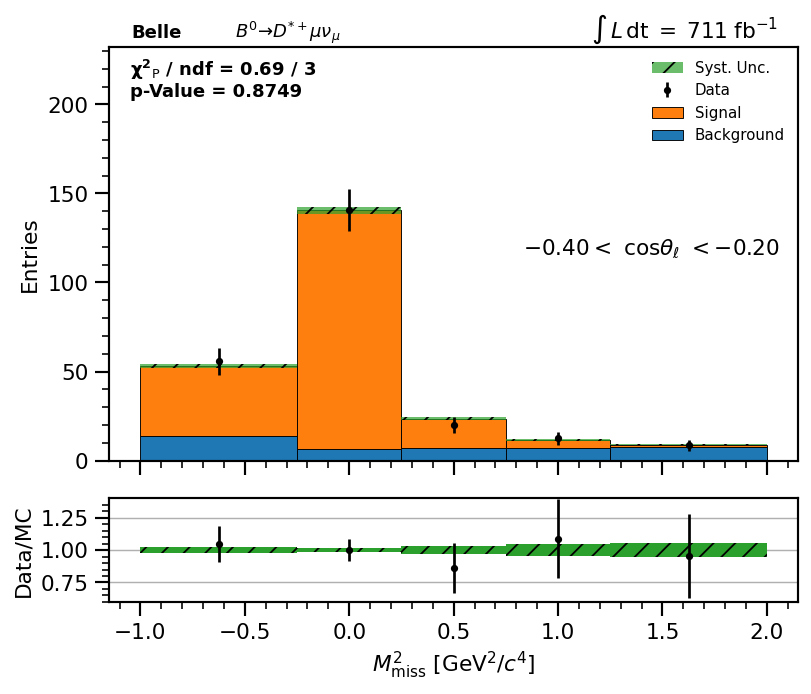

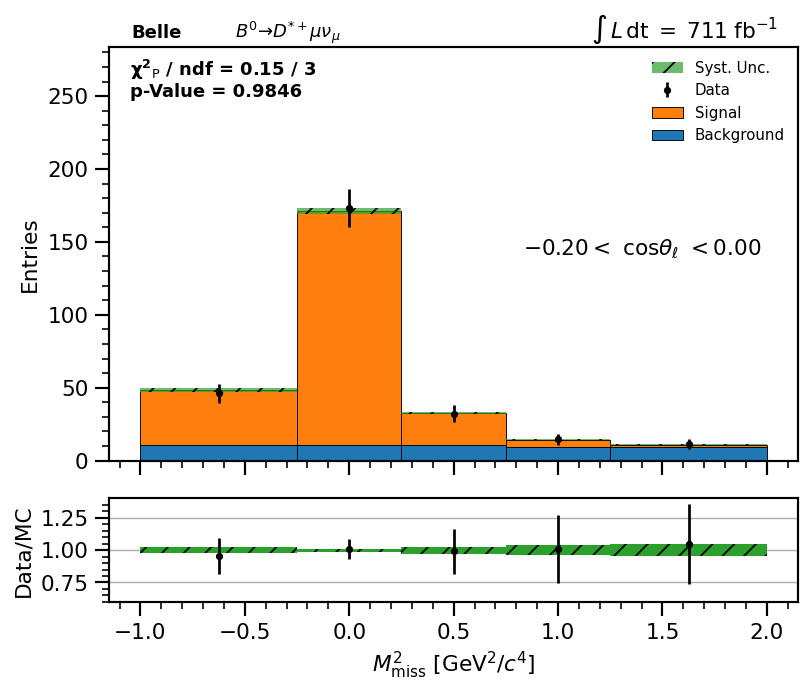

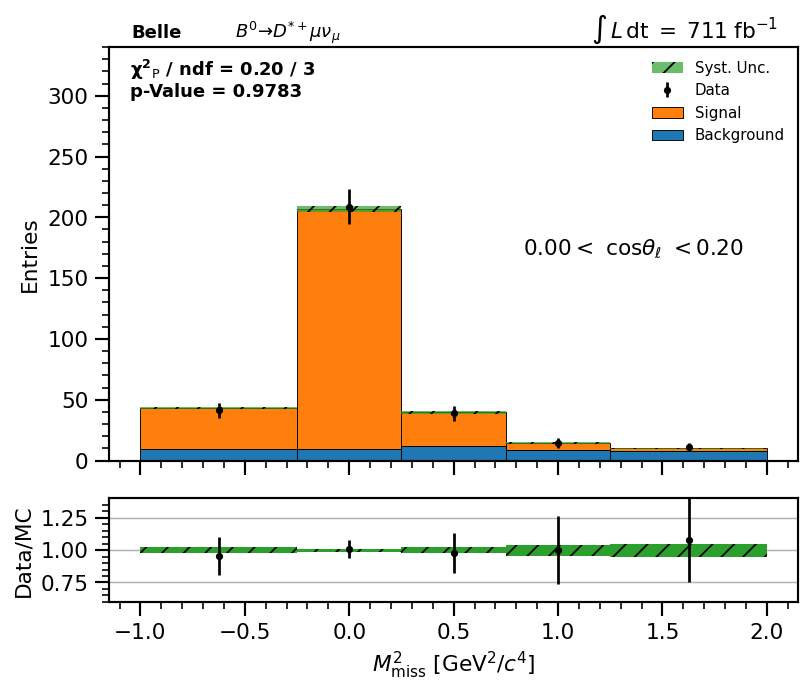

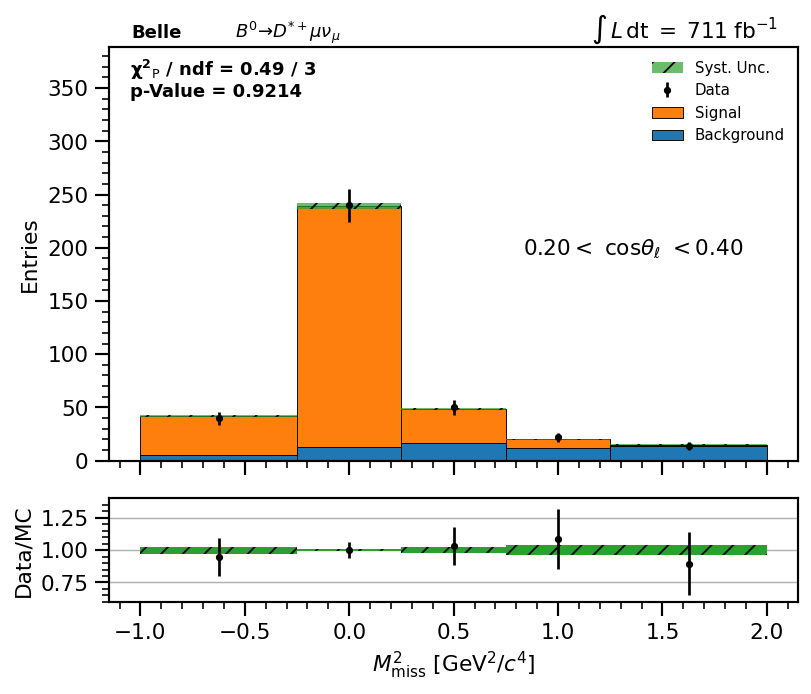

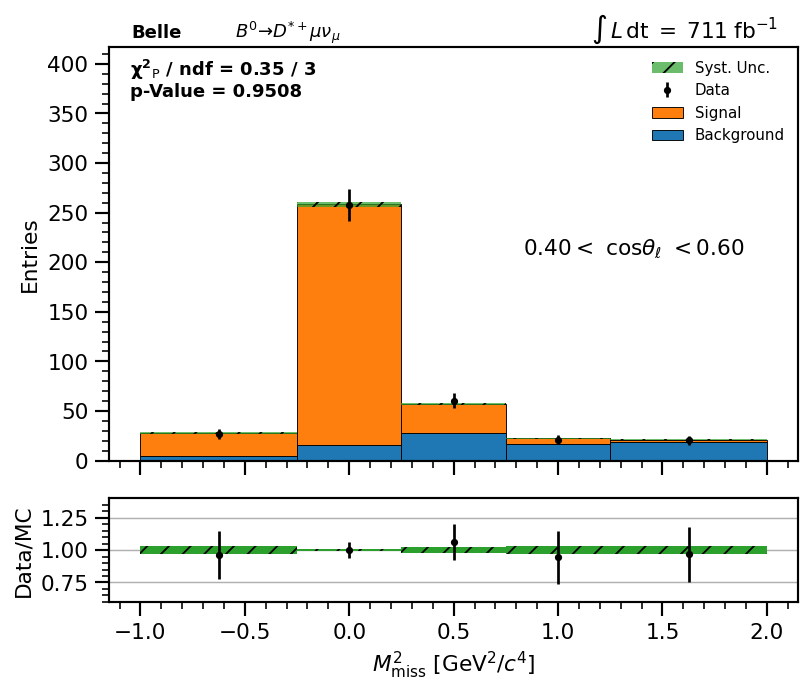

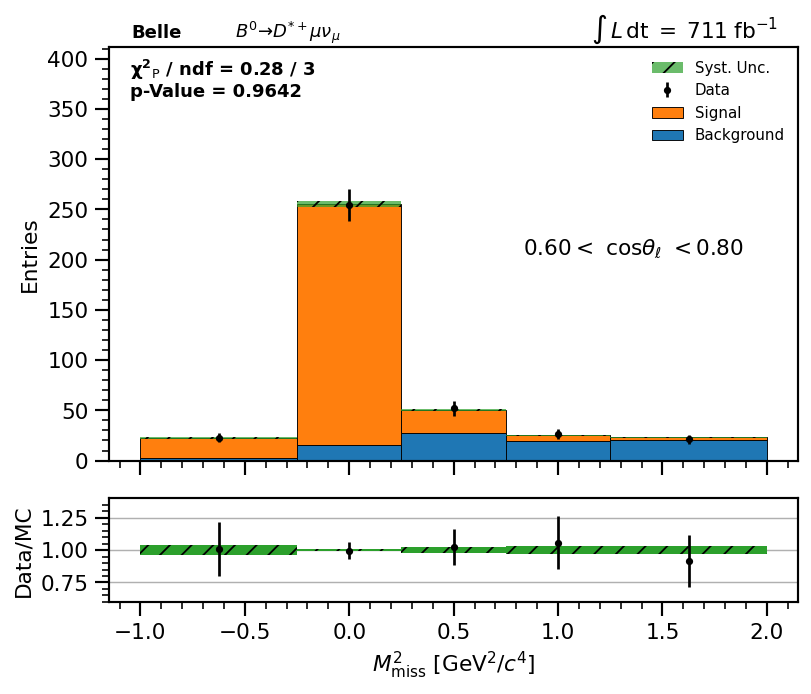

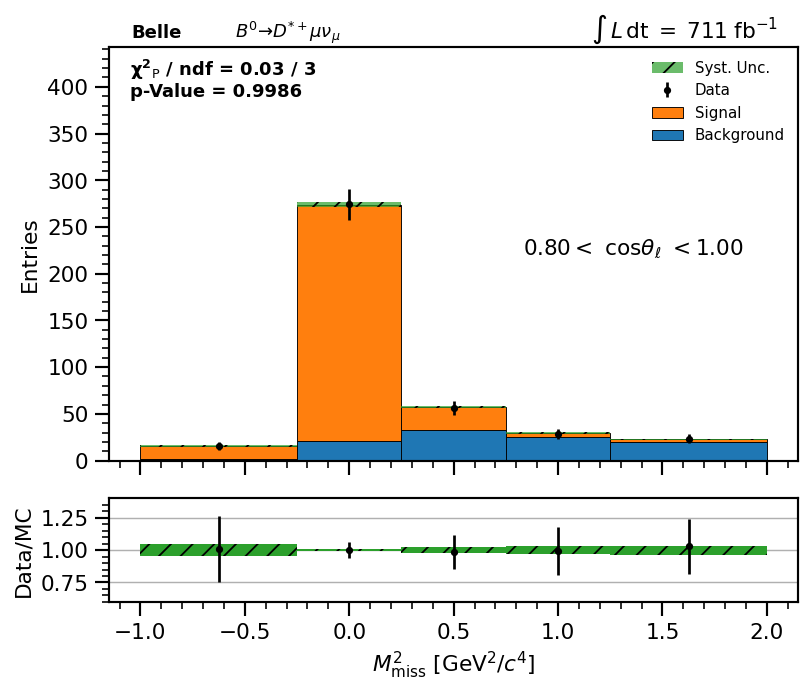

In [40]:
for channel in channels:
    for voi in fit_vois:
        bin_edges = bin_edges_all[voi]
        for i_bin, voi_bin in enumerate(zip(bin_edges, bin_edges[1:])):
            templates = templates_post_fit[channel][voi][i_bin]
            fig, ax = plot_templates(
                templates=templates,
                template_categories=template_category_names,
                bins=fit_bins,
                var_str=fit_variable_label,
                unit=fit_variable_unit,
                y_str="Entries",
                data=data_type,
                color_dict=color_dict,
                label_dict=label_dict,
                full_systematic_covariance=full_covariance_for_plotting[channel][voi][i_bin],
            )

            add_lumi(ax[0], 711)
            add_watermark(ax[0], channel_label[channel], fontsize=10)
            add_channel(ax[0], f"${voi_bin[0]:.2f} <$ " + r"{}".format(voi_labels[voi]) + f" $< {voi_bin[1]:.2f}$", px=0.6, py=0.5)
            annotate_gof(ax, templates, len(fit_bins) - 1 - len(template_categories), option=data_type)
            plt.tight_layout()
            plt.savefig(f"{plotoutdir}/postfit_channel{channel}_{fit_variable}_{voi}_{i_bin}.pdf", transparent=True)
            plt.savefig(f"{plotoutdir}/postfit_channel{channel}_{fit_variable}_{voi}_{i_bin}.png", transparent=True) 
            plt.show()
            plt.close()

In [41]:
yields = []
index = []
for channel in channels:
    for voi in fit_vois:
        bin_edges = bin_edges_all[voi]
        for i_bin, voi_bin in enumerate(zip(bin_edges, bin_edges[1:])):
            index.append((channel_label[channel], voi_labels[voi], f"[{voi_bin[0]:.2f}, {voi_bin[1]:.2f}]"))
            yields.append({
                "$\nu_\mathrm{sig}$ Pre": ufloat(fit_results[channel][voi][i_bin].x0[0], fit_results[channel][voi][i_bin].covariance0[0, 0]**0.5),
                "$\nu_\mathrm{sig}$ stat. only": ufloat(fit_results[channel][voi][i_bin].x[0], fit_results[channel][voi][i_bin].covariance[0, 0]**0.5),
                "$\nu_\mathrm{sig}$ stat. + MC stat.": ufloat(fit_results_with_uncorrelated_systematics[channel][voi][i_bin].x[0], fit_results_with_uncorrelated_systematics[channel][voi][i_bin].covariance[0, 0]**0.5),
                "$\nu_\mathrm{sig}$ stat. + MC stat. + shape": ufloat(fit_results_with_systematics[channel][voi][i_bin].x[0], fit_results_with_systematics[channel][voi][i_bin].covariance[0, 0]**0.5),
                "$\nu_\mathrm{bkg}$ Pre": ufloat(fit_results[channel][voi][i_bin].x0[1], fit_results[channel][voi][i_bin].covariance0[1, 1]**0.5),
                "$\nu_\mathrm{bkg}$ stat. only": ufloat(fit_results[channel][voi][i_bin].x[1], fit_results[channel][voi][i_bin].covariance[1, 1]**0.5),
                "$\nu_\mathrm{bkg}$ stat. + MC stat.": ufloat(fit_results_with_uncorrelated_systematics[channel][voi][i_bin].x[1], fit_results_with_uncorrelated_systematics[channel][voi][i_bin].covariance[1, 1]**0.5),
                "$\nu_\mathrm{bkg}$ stat. + MC stat. + shape": ufloat(fit_results_with_systematics[channel][voi][i_bin].x[1], fit_results_with_systematics[channel][voi][i_bin].covariance[1, 1]**0.5),
                r"$\chi^2$ Pre": chi2_from_templates(templates_pre_fit[channel][voi][i_bin], option=data_type),
                r"$\chi^2$ Post": chi2_from_templates(templates_post_fit[channel][voi][i_bin], option=data_type),
                r"$\chi^2$ / ndf Pre": "{:.0f} / {}".format(chi2_from_templates(templates_pre_fit[channel][voi][i_bin], option=data_type), len(fit_bins) - 1),
                r"$\chi^2$ / ndf Post": "{:.0f} / {}".format(chi2_from_templates(templates_post_fit[channel][voi][i_bin], option=data_type), len(fit_bins) - 1 - len(template_categories)),
            })
            
index = pd.MultiIndex.from_tuples(index, names=["Channel", "Variable", "voi bin"])
yields = pd.DataFrame(yields, index=index)
yields["$\nu_\mathrm{sig}$ Post/Pre"] = yields["$\nu_\mathrm{sig}$ stat. + MC stat. + shape"] / yields["$\nu_\mathrm{sig}$ Pre"]
yields["$\nu_\mathrm{bkg}$ Post/Pre"] = yields["$\nu_\mathrm{bkg}$ stat. + MC stat. + shape"] / yields["$\nu_\mathrm{bkg}$ Pre"]

In [42]:
yields["$\nu_\mathrm{sig}$"] = yields[["$\nu_\mathrm{sig}$ stat. + MC stat. + shape"]].apply(lambda x: unp.nominal_values(x))
yields["$\sigma_\mathrm{stat}$"] = yields[["$\nu_\mathrm{sig}$ stat. only"]].apply(lambda x: unp.std_devs(x))
yields["$\sigma_\mathrm{MC stat}$"] = yields[["$\nu_\mathrm{sig}$ stat. only", "$\nu_\mathrm{sig}$ stat. + MC stat."]].apply(lambda x: (unp.std_devs(x[1])**2 - unp.std_devs(x[0])**2)**0.5, axis=1)
yields["$\sigma_\mathrm{shape}$"] = yields[["$\nu_\mathrm{sig}$ stat. + MC stat.", "$\nu_\mathrm{sig}$ stat. + MC stat. + shape"]].apply(lambda x: (unp.std_devs(x[1])**2 - unp.std_devs(x[0])**2)**0.5, axis=1)
yields["$\sigma_\mathrm{shape}$"] = yields["$\sigma_\mathrm{shape}$"].replace(np.NaN, 0.00)

In [43]:
yields

$\nu_\mathrm{sig}$ Pre  \
Channel                      Variable           voi bin                                 
$B^0 \to D^{*+} e \nu_e$     $w$                [1.00, 1.05]               65.4+/-1.7   
                                                [1.05, 1.10]              113.9+/-1.9   
                                                [1.10, 1.15]              174.9+/-2.1   
                                                [1.15, 1.20]              235.4+/-2.3   
                                                [1.20, 1.25]              291.6+/-2.4   
                                                [1.25, 1.30]              314.1+/-2.4   
                                                [1.30, 1.35]              349.4+/-2.5   
                                                [1.35, 1.40]              344.8+/-2.5   
                                                [1.40, 1.45]              324.8+/-2.4   
                                                [1.45, 2.00]              315.1+/-2.4   
                             $\cos \theta_\ell$ [-1.00, -0.80]             70.8+/-1.7   
                                                [-0.80, -0.60]            136.7+/-1.9   
                                                [-0.60, -0.40]            181.2+/-2.1   
                                                [-0.40, -0.20]            234.9+/-2.2   
                                                [-0.20, 0.00]             288.5+/-2.4   
                                                [0.00, 0.20]              304.7+/-2.4   
                                                [0.20, 0.40]              318.3+/-2.4   
                                                [0.40, 0.60]              321.8+/-2.4   
                                                [0.60, 0.80]              330.2+/-2.5   
                                                [0.80, 1.00]              301.2+/-2.4   
$B^0 \to D^{*+} \mu \nu_\mu$ $w$                [1.00, 1.05]               66.0+/-1.7   
                                                [1.05, 1.10]              112.4+/-1.9   
                                                [1.10, 1.15]              161.4+/-2.1   
                                                [1.15, 1.20]              213.1+/-2.2   
                                                [1.20, 1.25]              263.2+/-2.3   
                                                [1.25, 1.30]              291.9+/-2.4   
                                                [1.30, 1.35]              298.5+/-2.4   
                                                [1.35, 1.40]              291.3+/-2.4   
                                                [1.40, 1.45]              252.4+/-2.3   
                                                [1.45, 2.00]              232.7+/-2.2   
                             $\cos \theta_\ell$ [-1.00, -0.80]             38.0+/-1.4   
                                                [-0.80, -0.60]             73.8+/-1.7   
                                                [-0.60, -0.40]            131.0+/-1.9   
                                                [-0.40, -0.20]            193.8+/-2.1   
                                                [-0.20, 0.00]             239.4+/-2.2   
                                                [0.00, 0.20]              270.5+/-2.3   
                                                [0.20, 0.40]              303.6+/-2.4   
                                                [0.40, 0.60]              304.7+/-2.4   
                                                [0.60, 0.80]              302.6+/-2.4   
                                                [0.80, 1.00]              296.1+/-2.4   

                                                               $\nu_\mathrm{sig}$ stat. only  \
Channel                      Variable           voi bin                                        
$B^0 \to D^{*+} e \nu_e$     $w$                [1.00, 1.05]                          63+/-9   
                                    

# FitCorrelations

We fit marginalized distributions, so we have to figure out the correlations.

***
### Exercise 2: Bootstrapping Statistical Correlation

We determine the statistical correlation of the data by sampling $n$ times with replacement and repeat the fit with the systematics
fixed to the best fit value (i.e., we fit only the signal and background yield). With the $n$ fit results we determine the Pearson correlation
coefficient. 

The sample size of the bootstraps has to be chosen such that correlations can be resolved statistically significant down to the correlation coefficients which we want to be resolved.
E.g., to resolve stasticical significant correlation coefficients of $r=0.01$, we would need approximately 10'000 bootstraps. In the interest of time, we will work with 100-1000 today.

Because we know that the statistical correlation between neighbouring bins of the same differential variable, e.g., $w_i$ and $w_{i+1}$ is 0, we set this to 0
instead of using the estimated correlation, which fluctuates around 0 within the 68\% CL.


In [44]:
data_type = "data"
number_of_bootstraps = 10  # Tune this number up when you think you are ready

Ex. 2 a) Determine the size of the boostrap, which should be a randon number drawn from a poisson distribution, with expectation value of your full data sample. Make use of `scipy.stats.poisson`

Ex. 2 b) Sample with replacement, make use of the pandas build in function `DataFrame.sample()`

Look in the cell below and fill in the correct lines.

In [45]:
toys = []

df_data_tmp = df_data.query(f"{fit_range[0]} <= {fit_variable} <= {fit_range[1]}")[["daughter__bo1__cm__spextraInfo__bodecayModeID__bc__bc", *fit_vois, fit_variable]]

for _ in tqdm(range(0, number_of_bootstraps)):
    templates_for_correlation = {}
    
     
    bootstrap_size = 0 # <<< Ex. 2a) This should be an integer. scipy.stats.poisson.rvs(len(df_data_tmp))
    df_data_boostrap = pd.DataFrame # Ex. 2b) This should be a data frame, a boostrap from your original data sample `df_data_tmp`. 
    
    for channel in channels:
        templates_for_correlation[channel] = {}

        for voi in fit_vois:
            templates_for_correlation[channel][voi] = {}

            bin_edges = bin_edges_all[voi]
            for i_bin, voi_bin in enumerate(zip(bin_edges, bin_edges[1:])):

                
                query = f"daughter__bo1__cm__spextraInfo__bodecayModeID__bc__bc == {channel} and {voi_bin[0]} < {voi} < {voi_bin[1]}"
                data = df_data_boostrap.query(query)[[fit_variable]]

                templates_for_correlation[channel][voi][i_bin] = {}
                for category in template_categories:
                    templates_for_correlation[channel][voi][i_bin][category] = templates_post_fit[channel][voi][i_bin][category]

                bin_content = np.histogram(data[fit_variable], bins=fit_bins, range=fit_range)[0]
                bin_errors = bin_content**0.5
                templates_for_correlation[channel][voi][i_bin]["data"] = unp.uarray(bin_content, bin_errors)
    toys.append(templates_for_correlation)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.76it/s]


In [46]:
toy_fits = []

for toy in tqdm(toys):
    fit_results_for_correlation = {}

    fit_options = {
        "options": {"maxiter": 200, "disp": False},  
    }

    for channel in channels:
        fit_results_for_correlation[channel] = {}
        for voi in fit_vois:
            bin_edges = bin_edges_all[voi]
            fit_results_for_correlation[channel][voi] = {}        
            for i_bin, _ in enumerate(zip(bin_edges, bin_edges[1:])):
                try:
                    fit_result = run_fit(L, toy[channel][voi][i_bin], "data", template_categories, calculate_covariance=False, **fit_options)  # We use real data to determine the correlation matrix
                    fit_results_for_correlation[channel][voi][i_bin] = fit_result
                    if fit_result.status:
                        print(f"{channel}_{voi}_{i_bin}_{fit_result.message}")
                        print(fit_result.x)
                except:
                    templates = toy[channel][voi][i_bin]
                    fig, ax = plot_templates(
                        templates=templates,
                        template_categories=template_category_names,
                        bins=fit_bins,
                        var_str=fit_variable_label,
                        unit=fit_variable_unit,
                        y_str="Entries",
                        data=data_type,
                        color_dict=color_dict,
                        label_dict=label_dict,
                        full_systematic_covariance=full_covariance_for_plotting[channel][voi][i_bin],
                    )
                    add_lumi(ax[0], 711)
                    add_watermark(ax[0], channel_label[channel], fontsize=10)
                    add_channel(ax[0], f"${voi_bin[0]:.2f} <$ " + r"{}".format(voi_labels[voi]) + f" $< {voi_bin[1]:.2f}$", px=0.6, py=0.5)
                    annotate_gof(ax, templates, len(fit_bins) - 1 - len(template_categories))
                    plt.tight_layout()
                    plt.show()
                    plt.close()
                    
    
    toy_fits.append(fit_results_for_correlation)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.44it/s]


Ex. 3 c) From the toy fits, calcultate the correlation coefficient. Make use of numpy's `np.corrcoef`. Because of the way our array is oriented, look at the option `rowvar`.

Ex. 4 d) We know there is no statistical correlation between neighbouring bins, only across different distributions (Why?). Set the corresponding elements to 0.

In [47]:
statistical_correlation = {}
for channel in channels: 
    toy_yields = []
    for toy_fit in toy_fits:
        a = np.array([toy_fit[channel]["wReco"][i_bin].x[0] for i_bin in range(10)])
        b = np.array([toy_fit[channel]["costhetalReco"][i_bin].x[0] for i_bin in range(10)])
        toy_yields.append(np.array([*a, *b]))
    toy_yields = np.array(toy_yields)
    
    correlation_matrix = None  # <<< Ex 3 c) Calculate the correlation matrix
    
    # Ex 3 d) Set the entries we know to be 0 to 0.
    
    statistical_correlation[channel] = np.clip(correlation_matrix, a_min=0, a_max=None)
statistical_correlation["full"] = scipy.linalg.block_diag(*[statistical_correlation[channel] for channel in channels])

In [48]:
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

def plot_correlation(matrix, bin_edges, fit_vois, title, channel=None, source=None):

    fig, ax = plt.subplots(dpi=130, figsize=(6.4, 4.4 / 0.8))
    im = ax.imshow(matrix, vmin=-1, vmax=1, cmap=plt.get_cmap("RdBu_r"))
    
    tmp = {}
    for voi in fit_vois:
        tmp[voi] = np.array([(lower, upper) for lower, upper in zip(bin_edges_all[voi], bin_edges_all[voi][1:])])
    tmp = np.array([b for voi in fit_vois for b in tmp[voi]])

    # We want to show all ticks...
    ax.set_xticks(np.arange(len(tmp)))
    ax.set_yticks(np.arange(len(tmp)))
    # ... and label them with the respective list entries
    ax.set_xticklabels([f"[{lower:.2f}, {upper:.2f}]" for lower, upper in tmp], rotation=90, fontsize=6)
    ax.set_yticklabels([f"[{lower:.2f}, {upper:.2f}]" for lower, upper in tmp], fontsize=6)

    ax.xaxis.set_minor_locator(MultipleLocator(1))
    ax.yaxis.set_minor_locator(MultipleLocator(1))

    ax.axvline(9.5, color="black")
    ax.axvline(19.5, color="black")
    
    ax.axhline(9.5, color="black")
    ax.axhline(19.5, color="black")

    ax.text(4, -1.1, r"$w$", fontsize=10)
    ax.text(13, -1.1, r"$\cos \theta_\ell$", fontsize=10)

    ax.text(19.6, 4, r"$w$", fontsize=10, rotation=-90)
    ax.text(19.6, 15, r"$\cos \theta_\ell$", fontsize=10, rotation=-90)
    
    ax.set_title(title, y=1.04)

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.25)
    plt.colorbar(im, cax=cax)

    plt.tight_layout()
    if channel is not None and source is not None:
        plt.savefig(f"{plotoutdir}/correlation{channel}_{source}.pdf", transparent=True)
        plt.savefig(f"{plotoutdir}/correlation{channel}_{source}.png", transparent=True)     
    plt.show()
    plt.close()

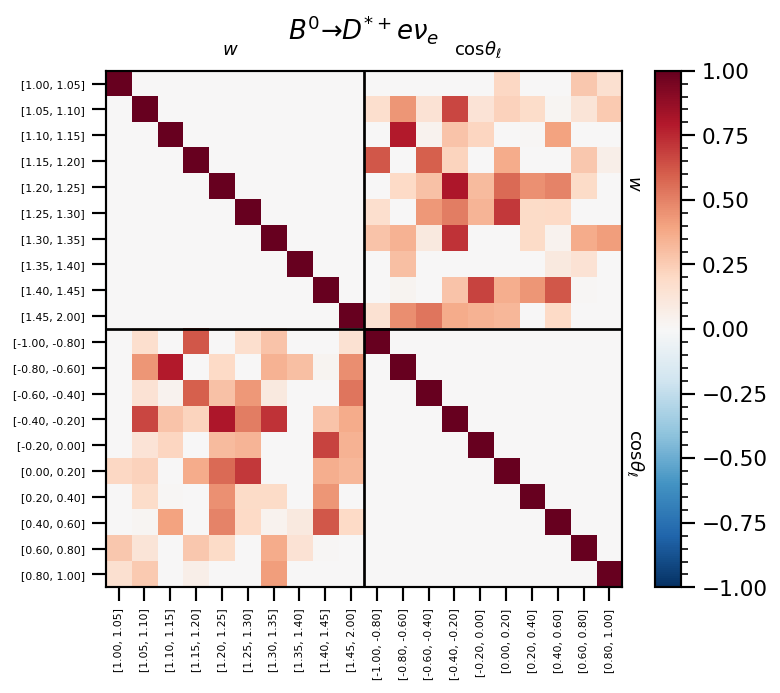

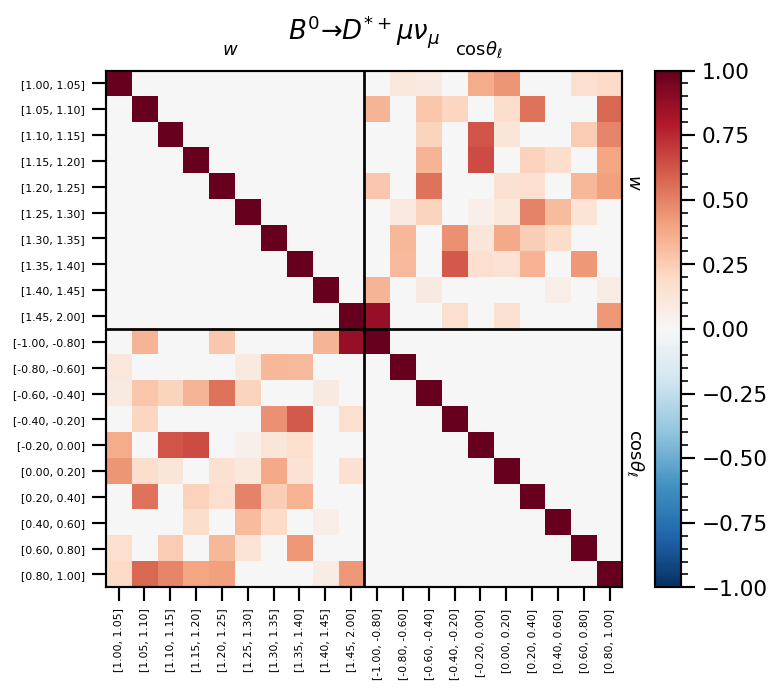

In [49]:
for channel in channels:
    plot_correlation(statistical_correlation[channel], bin_edges_all, fit_vois, channel_label[channel], channel, "statistical")

In [50]:
statistical_covariance = {}
for channel in channels:
    statistical_covariance[channel] = np.outer(yields.loc[channel_label[channel], '$\sigma_\mathrm{stat}$'], yields.loc[channel_label[channel], '$\sigma_\mathrm{stat}$']) * statistical_correlation[channel]
statistical_covariance["full"] = scipy.linalg.block_diag(*[statistical_covariance[channel] for channel in channels])

/tmp/ipykernel_12339/2840802001.py:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  statistical_covariance[channel] = np.outer(yields.loc[channel_label[channel], '$\sigma_\mathrm{stat}$'], yields.loc[channel_label[channel], '$\sigma_\mathrm{stat}$']) * statistical_correlation[channel]


### Shape Systematics

We treat the shape systematics from other sources (all but MC limited statistics) as fully correlated across the different bins. 
This systematic uncertainty is negligibly small, so this treatment is a good approximation without any significant influence on the final result.

In [51]:
shape_systematics_covariance = {}
shape_systematics_covariance["full"] = np.outer(yields['$\sigma_\mathrm{shape}$'].values, yields['$\sigma_\mathrm{shape}$'].values)
for i, channel in enumerate(channels):
    shape_systematics_covariance[channel] = shape_systematics_covariance["full"][i*40:(i+1)*40, i*40:(i+1)*40]

In [52]:
yields["$\sigma_\mathrm{tot}$"] = yields[[
    '$\sigma_\mathrm{stat}$',
    '$\sigma_\mathrm{MC stat}$',
    '$\sigma_\mathrm{shape}$',
]].apply(lambda x: sum(x**2)**0.5, axis=1)

In [53]:
yields[[
    "$\nu_\mathrm{sig}$",
    "$\sigma_\mathrm{tot}$",
    '$\sigma_\mathrm{stat}$',
    '$\sigma_\mathrm{MC stat}$',
    '$\sigma_\mathrm{shape}$',
]]

$\nu_\mathrm{sig}$  \
Channel                      Variable           voi bin                              
$B^0 \to D^{*+} e \nu_e$     $w$                [1.00, 1.05]                 63.23   
                                                [1.05, 1.10]                121.77   
                                                [1.10, 1.15]                162.50   
                                                [1.15, 1.20]                243.61   
                                                [1.20, 1.25]                289.84   
                                                [1.25, 1.30]                316.97   
                                                [1.30, 1.35]                355.11   
                                                [1.35, 1.40]                338.96   
                                                [1.40, 1.45]                327.05   
                                                [1.45, 2.00]                313.76   
                             $\cos \theta_\ell$ [-1.00, -0.80]               69.53   
                                                [-0.80, -0.60]              127.11   
                                                [-0.60, -0.40]              184.71   
                                                [-0.40, -0.20]              238.38   
                                                [-0.20, 0.00]               284.37   
                                                [0.00, 0.20]                297.12   
                                                [0.20, 0.40]                324.28   
                                                [0.40, 0.60]                315.09   
                                                [0.60, 0.80]                341.08   
                                                [0.80, 1.00]                298.86   
$B^0 \to D^{*+} \mu \nu_\mu$ $w$                [1.00, 1.05]                 60.47   
                                                [1.05, 1.10]                102.09   
                                                [1.10, 1.15]                154.55   
                                                [1.15, 1.20]                208.48   
                                                [1.20, 1.25]                262.97   
                                                [1.25, 1.30]                301.94   
                                                [1.30, 1.35]                299.26   
                                                [1.35, 1.40]                288.33   
                                                [1.40, 1.45]                245.65   
                                                [1.45, 2.00]                244.25   
                             $\cos \theta_\ell$ [-1.00, -0.80]               41.31   
                                                [-0.80, -0.60]               74.76   
                                                [-0.60, -0.40]              132.93   
                                                [-0.40, -0.20]              195.98   
                                                [-0.20, 0.00]               226.28   
                                                [0.00, 0.20]                267.04   
                                                [0.20, 0.40]                304.60   
                                                [0.40, 0.60]                302.92   
                                                [0.60, 0.80]                290.73   
                                                [0.80, 1.00]                297.83   

                                                                $\sigma_\mathrm{tot}$  \
Channel                      Variable           voi bin                                 
$B^0 \to D^{*+} e \nu_e$     $w$                [1.00, 1.05]                     9.46   
                                                [1.05, 1.10]                    14.74   
                                                [1.10, 1.15]                    16.91   
      

In [54]:
yields.to_pickle(os.path.join(plotoutdir, "yields.pkl"))

In [55]:
full_correlation_of_spectrum = {}
stat_correlation_of_spectrum = {}

full_correlation_of_spectrum["full"] = sum([statistical_covariance["full"], shape_systematics_covariance["full"]])
full_correlation_of_spectrum["full"] = full_correlation_of_spectrum["full"] / np.outer(full_correlation_of_spectrum["full"].diagonal()**0.5, full_correlation_of_spectrum["full"].diagonal()**0.5)
stat_correlation_of_spectrum["full"] = statistical_covariance["full"] / np.outer(statistical_covariance["full"].diagonal()**0.5, statistical_covariance["full"].diagonal()**0.5)

for i, channel in enumerate(channels):
    full_correlation_of_spectrum[channel] = full_correlation_of_spectrum["full"][i*20:(i+1)*20, i*20:(i+1)*20] 
    stat_correlation_of_spectrum[channel] = stat_correlation_of_spectrum["full"][i*20:(i+1)*20, i*20:(i+1)*20] 

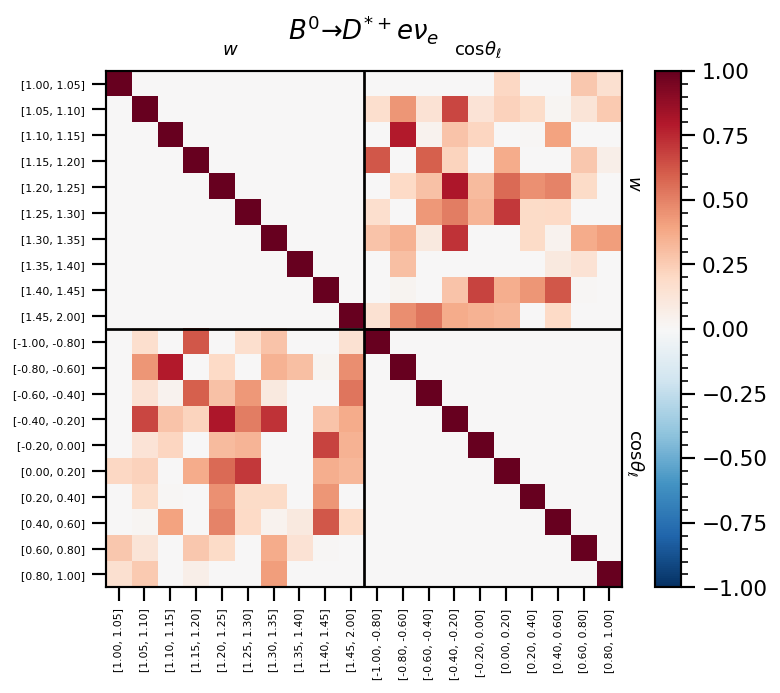

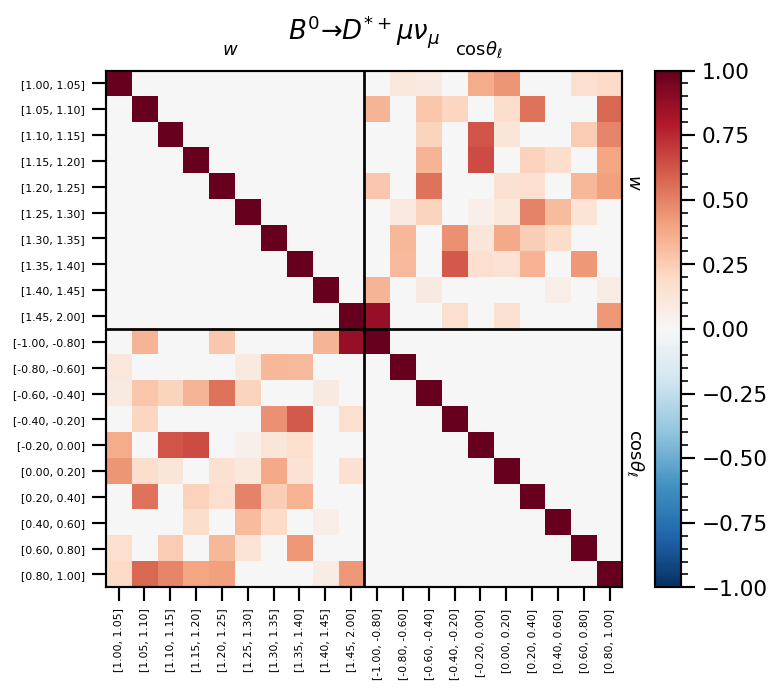

In [56]:
for channel in channels:
    plot_correlation(full_correlation_of_spectrum[channel], bin_edges_all, fit_vois, channel_label[channel], channel, f"full_correlation")

In [57]:
for channel in channels:
    pd.DataFrame(statistical_correlation[channel]).to_pickle(os.path.join(plotoutdir, f"correlation_stat_{channel}.pkl"))
    pd.DataFrame(full_correlation_of_spectrum[channel]).to_pickle(os.path.join(plotoutdir, f"correlation_{channel}.pkl"))
pd.DataFrame(statistical_correlation["full"]).to_pickle(os.path.join(plotoutdir, f"correlation_stat_full.pkl"))
pd.DataFrame(full_correlation_of_spectrum["full"]).to_pickle(os.path.join(plotoutdir, f"correlation_full.pkl"))

In [58]:
tmp = {}
for voi in fit_vois:
    tmp[voi] = np.array([(lower, upper) for lower, upper in zip(bin_edges_all[voi], bin_edges_all[voi][1:])])
tmp = np.array([b for voi in fit_vois for b in tmp[voi]])

for channel in channels:
    with open(os.path.join(plotoutdir, f"full_correlation_{channel}.tex"), "w") as f:
        # f.write(pd.DataFrame(full_correlation_of_spectrum[channel], columns=[f"[{lower:.2f}, {upper:.2f}]" for lower, upper in tmp], index=[f"[{lower:.2f}, {upper:.2f}]" for lower, upper in tmp]).to_latex(escape=False))
        f.write(pd.DataFrame(full_correlation_of_spectrum[channel]).to_latex(escape=False))